In [1]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", ".."))
sys.path.append(os.path.join(os.getcwd(), ".."))
sys.path

import pandas as pd
import numpy as np
import os
import re

import matplotlib
import matplotlib.pyplot as plt

In [2]:
!pip install seaborn==0.12.0

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [3]:
import seaborn as sns
sns.__version__

'0.12.0'

In [4]:
pd.__version__

'1.3.4'

In [5]:
#perturbation_processed_output_dir = os.path.join(os.getcwd(), "..", "..", "..", "..", "..", "output/raw/coronaviridae_s_prot_perturbation/20240320/sars-cov-2/uniref90/cov-S-aligned-multi-transfer_learning_mlm_fnn_2l_lr1e-4/processed")
perturbation_output_filepath = os.path.join(os.getcwd(), "..", "..", "..", "..", "..", "output/raw/coronaviridae_s_prot_perturbation/20240702/sars-cov-2/uniref90/cov-S-multi-transfer_learning_mlm_hybrid_attn_fnn_2l_lr1e-4/aligned_msl256_s64/processed/tl_tf_multi_coronaviridae_s_uniref90_sars_cov_2_aligned.csv_WIV04.csv")

human_label = "Human"
pred_diff_col = f"{human_label}_pred_diff"
classes=["Cat", "Chicken", "Chinese rufous horseshoe bat", "Ferret", "Gray wolf", "Horshoe bat", "Human", "Pig"]

In [6]:
def get_perturbation_output(perturbation_output_filepath):
    df = pd.read_csv(perturbation_output_filepath)
    orig_seq_df = df[df["orig_token"] == df["new_token"]]
    orig_pred_val = orig_seq_df[human_label].values[0]
    orig_pred_class = orig_seq_df[classes].idxmax(axis=1).values[0]

    df[pred_diff_col] = df[human_label] - orig_pred_val
    df[f"abs_{pred_diff_col}"] = df[pred_diff_col].abs()
    df["orig_y_pred"] = orig_pred_class
    df["new_y_pred"] = df[classes].idxmax(axis=1)
    return df

In [7]:
import textwrap
def wrap_xticklabels(ax, label_width=10, break_long_words=False):
    wrapped_labels = []
    for label in ax.get_xticklabels():
        label_text = label.get_text()
        wrapped_labels.append(textwrap.fill(text=label_text, width=label_width, break_long_words=break_long_words))
    ax.set_xticklabels(wrapped_labels, rotation=0)
    
def wrap_yticklabels(ax, label_width=10, break_long_words=False):
    wrapped_labels = []
    for label in ax.get_yticklabels():
        label_text = label.get_text()
        wrapped_labels.append(textwrap.fill(text=label_text, width=label_width, break_long_words=break_long_words))
    ax.set_yticklabels(wrapped_labels, rotation=0)

In [8]:
def get_distribution_df(df, orig_token, perturb_pos, perturbation_id, perturbation_id_label):
    print(f"Perturbation id = {perturbation_id}")
    # perturbation df
    perturbation_df = df[df["perturbation_id"] == perturbation_id].copy()
    perturbation_df.loc[:, "type"] = "mutation"
    perturbation_id_x = perturbation_id[:-1]
    perturbation_id_x += "X"
    print(perturbation_id_x)
    # not perturbation df: all other perturbations in all sequences
#     non_perturbation_df = df[df["perturbation_id"] != perturbation_id].copy()
#     non_perturbation_df.loc[:, "type"] = "all seq, all non-mutatn perturbatns"
    perturbation_id_x_df = df[df["perturbation_id"] == perturbation_id_x].copy()
    perturbation_id_x_df["type"] = "mutation w/ new token = X"
    # all other perturbations in the same position in all sequences
    pos_non_perturbation_df = df[(df["perturb_seq_pos"] == perturb_pos) &
                                 (df["perturbation_id"] != perturbation_id_x) &
                                 (df["perturbation_id"] != perturbation_id)].copy()
    pos_non_perturbation_df.loc[:, "type"] = "all seq, same pos non-mutation perturbations"
    
    # sequences with original token
    sequence_w_orig_token_df = df[(df["orig_token"] == orig_token) & (df["perturb_seq_pos"] == perturb_pos)].copy()
    sequence_w_orig_token_ids = list(sequence_w_orig_token_df["uniref90_id"].unique())
    
    # all other perturbations in sequences with original token
#     swo_non_perturbation_df = non_perturbation_df[non_perturbation_df["uniref90_id"].isin(sequence_w_orig_token_ids)].copy()
#     swo_non_perturbation_df.loc[:, "type"] = "seq w/ orig token, all non-mutatn perturbatns"
    
    # all other perturbations in the same positions in sequences with the original token
    swo_pos_non_perturbation_df = sequence_w_orig_token_df[(sequence_w_orig_token_df["perturbation_id"] != perturbation_id) &
                                                           (sequence_w_orig_token_df["new_token"] != "X")].copy()
    swo_pos_non_perturbation_df.loc[:, "type"] = "seq w/ orig token, same pos non-mutation perturbations"
    
#     print(f"perturbation = {perturbation_df.shape}")
#     print(f"all seq, all non-perturbations = {non_perturbation_df.shape}")
#     print(f"all seq, same pos non-perturbations = {pos_non_perturbation_df.shape}")
#     print(f"sequence_w_orig_token_df = {sequence_w_orig_token_df.shape}")
#     print(f"seq w/ orig token, all non-perturbations = {swo_non_perturbation_df.shape}")
#     print(f"seq w/ orig token, same pos non-perturbations = {swo_pos_non_perturbation_df.shape}")
    
    # result_df = pd.concat([perturbation_df, non_perturbation_df, pos_non_perturbation_df, swo_non_perturbation_df, swo_pos_non_perturbation_df])
    result_df = pd.concat([perturbation_df, perturbation_id_x_df, pos_non_perturbation_df, swo_pos_non_perturbation_df])
    result_df["label"] = perturbation_id_label
    return result_df

In [9]:
perturbed_output_df = get_perturbation_output(perturbation_output_filepath)
print(f"perturbed_output_df shape = {perturbed_output_df.shape}")

perturbed_output_df shape = (31826, 17)



#### WIV04 reference sequence

In [10]:
wiv04_aligned_file_path = os.path.join(os.getcwd(), "..", "..", "..", "..", "..", "input/data/coronaviridae/20240313/uniref/alignment/coronaviridae_s_uniref90_embl_hosts_pruned_metadata_corrected_species_virus_host_vertebrates_w_seq_t0.01_c8_aligned.csv")
wiv04_df = pd.read_csv(wiv04_aligned_file_path)
wiv04_df = wiv04_df[wiv04_df["uniref90_id"] == "WIV04"]
wiv04_df.head()

uniref90_id                                        aligned_seq  \
0       WIV04  --------------MFVFLVLLPLVSS--------Q----------...   

                                                 seq  \
0  MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...   

                                    virus_name virus_host_name  \
0  WIV04(MN996528.1) Wuhan variant index virus    homo sapiens   

  human_binary_label  
0       homo sapiens

In [11]:
wiv04_aligned_seq = wiv04_df["aligned_seq"].values[0]
print(len(wiv04_aligned_seq))
wiv04_aligned_seq

2418


'--------------MFVFLVLLPLVSS--------Q----------------CVN--------LTTRTQLPPAY----TNSFTRGVYYPDKVFRSSVLHSTQDLFLPF----------------FSNVTWFHAIHVSGT---------------NGTKRFDNPVLPFN-DGVYFASTEK---------SNIIRGWIFGTTLDSKTQSLLIVNNAT---------------------------N--------------------------VVIKVCEFQ----------------------FCNDPFLG-----VYYHKNNK------------SWMESEFRVY-----------------------------------------------------------------------------SSANNC--TFEYVSQPFLM------------DLEGKQG-NFKNLREFV------------------------------------------------------------------------------------------------------------------------------------------------------------------F-----------KNID-------------GYFKIYSKHTPIN--LVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIY------QTSNFRVQPTESIVRF----------------------------------------------------PNITNLCPFGEVFNATRF-ASVY--AWNRKRI----------SNCVADY--------------------------------------SVLYN----SASFST--------------------------------FKCYGVSP-------

In [12]:
wiv04_aligned_seq[:2049]

'--------------MFVFLVLLPLVSS--------Q----------------CVN--------LTTRTQLPPAY----TNSFTRGVYYPDKVFRSSVLHSTQDLFLPF----------------FSNVTWFHAIHVSGT---------------NGTKRFDNPVLPFN-DGVYFASTEK---------SNIIRGWIFGTTLDSKTQSLLIVNNAT---------------------------N--------------------------VVIKVCEFQ----------------------FCNDPFLG-----VYYHKNNK------------SWMESEFRVY-----------------------------------------------------------------------------SSANNC--TFEYVSQPFLM------------DLEGKQG-NFKNLREFV------------------------------------------------------------------------------------------------------------------------------------------------------------------F-----------KNID-------------GYFKIYSKHTPIN--LVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIY------QTSNFRVQPTESIVRF----------------------------------------------------PNITNLCPFGEVFNATRF-ASVY--AWNRKRI----------SNCVADY--------------------------------------SVLYN----SASFST--------------------------------FKCYGVSP-------

In [13]:
wiv04_aligned_seq[2049:]

'KVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFC-GKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAIC---------HDGKAHFPRE---GVFVS-----NGTHWFVTQRNFYEPQIITTDNTFVSGNCDVVIGIVNNTVYDPLQPEL----DSFKEELDKYFKNHTSPDVDLGDIS-GINASV--VNIQKEID--------------RLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIVMVTIML-CCMTS-----CCS-----------CLKG------------CCSCGSCCKFD-----------EDDSEPVLKGVKLHYT--'

In [14]:
wiv04_position_mapping = {}
pos = 0
for i, token in enumerate(wiv04_aligned_seq):
    if token == "-":
        continue
    else:
        pos += 1
        wiv04_position_mapping[i] = int(pos)
        
perturbed_output_df["perturb_seq_pos"] = perturbed_output_df["perturb_pos"].apply(lambda x: int(wiv04_position_mapping[x]) if x in wiv04_position_mapping else None)        
perturbed_output_df["perturb_seq_pos"] = perturbed_output_df["perturb_seq_pos"].astype("Int64")

In [15]:
perturbed_output_df

Cat   Chicken  Chinese rufous horseshoe bat    Ferret  Gray wolf  \
0      0.002760  0.000763                      0.110685  0.000500   0.005277   
1      0.000151  0.000020                      0.041477  0.000011   0.000405   
2      0.000156  0.000021                      0.040968  0.000011   0.000419   
3      0.000153  0.000020                      0.041202  0.000011   0.000412   
4      0.000156  0.000021                      0.041209  0.000011   0.000418   
...         ...       ...                           ...       ...        ...   
31821  0.000154  0.000020                      0.041178  0.000011   0.000413   
31822  0.000153  0.000020                      0.041230  0.000011   0.000411   
31823  0.000157  0.000021                      0.041254  0.000011   0.000421   
31824  0.000153  0.000020                      0.041196  0.000011   0.000412   
31825  0.000153  0.000020                      0.041226  0.000011   0.000412   

       Horshoe bat     Human       Pig uniref90_id y_true orig_token  \
0         0.035618  0.843437  0.000960       WIV04  Human          T   
1         0.007301  0.950608  0.000029       WIV04  Human          S   
2         0.007188  0.951209  0.000029       WIV04  Human          Y   
3         0.007239  0.950934  0.000029       WIV04  Human          T   
4         0.007248  0.950909  0.000030       WIV04  Human          S   
...            ...       ...       ...         ...    ...        ...   
31821     0.007235  0.950959  0.000029       WIV04  Human          D   
31822     0.007246  0.950899  0.000029       WIV04  Human          E   
31823     0.007262  0.950845  0.000030       WIV04  Human          I   
31824     0.007238  0.950940  0.000029       WIV04  Human          F   
31825     0.007247  0.950901  0.000029       WIV04  Human          S   

       perturb_pos new_token  Human_pred_diff  abs_Human_pred_diff  \
0             1674         N        -0.107556             0.107556   
1              433         L        -0.000386             0.000386   
2              940         Z         0.000216             0.000216   
3              198         M        -0.000059             0.000059   
4             2232         E        -0.000084             0.000084   
...            ...       ...              ...                  ...   
31821          645         S        -0.000034             0.000034   
31822         1780         A        -0.000094             0.000094   
31823         1666         K        -0.000148             0.000148   
31824           92         Y        -0.000053             0.000053   
31825          665         T        -0.000092             0.000092   

      orig_y_pred new_y_pred  perturb_seq_pos  
0           Human      Human              678  
1           Human      Human              172  
2           Human      Human              369  
3           Human      Human              108  
4           Human      Human             1147  
...           ...        ...              ...  
31821       Human      Human              198  
31822       Human      Human              773  
31823       Human      Human              670  
31824       Human      Human               43  
31825       Human      Human              205  

[31826 rows x 18 columns]

In [16]:
perturbed_output_df = perturbed_output_df[~perturbed_output_df["perturb_seq_pos"].isna()]

In [17]:
perturbed_output_df

Cat   Chicken  Chinese rufous horseshoe bat    Ferret  Gray wolf  \
0      0.002760  0.000763                      0.110685  0.000500   0.005277   
1      0.000151  0.000020                      0.041477  0.000011   0.000405   
2      0.000156  0.000021                      0.040968  0.000011   0.000419   
3      0.000153  0.000020                      0.041202  0.000011   0.000412   
4      0.000156  0.000021                      0.041209  0.000011   0.000418   
...         ...       ...                           ...       ...        ...   
31821  0.000154  0.000020                      0.041178  0.000011   0.000413   
31822  0.000153  0.000020                      0.041230  0.000011   0.000411   
31823  0.000157  0.000021                      0.041254  0.000011   0.000421   
31824  0.000153  0.000020                      0.041196  0.000011   0.000412   
31825  0.000153  0.000020                      0.041226  0.000011   0.000412   

       Horshoe bat     Human       Pig uniref90_id y_true orig_token  \
0         0.035618  0.843437  0.000960       WIV04  Human          T   
1         0.007301  0.950608  0.000029       WIV04  Human          S   
2         0.007188  0.951209  0.000029       WIV04  Human          Y   
3         0.007239  0.950934  0.000029       WIV04  Human          T   
4         0.007248  0.950909  0.000030       WIV04  Human          S   
...            ...       ...       ...         ...    ...        ...   
31821     0.007235  0.950959  0.000029       WIV04  Human          D   
31822     0.007246  0.950899  0.000029       WIV04  Human          E   
31823     0.007262  0.950845  0.000030       WIV04  Human          I   
31824     0.007238  0.950940  0.000029       WIV04  Human          F   
31825     0.007247  0.950901  0.000029       WIV04  Human          S   

       perturb_pos new_token  Human_pred_diff  abs_Human_pred_diff  \
0             1674         N        -0.107556             0.107556   
1              433         L        -0.000386             0.000386   
2              940         Z         0.000216             0.000216   
3              198         M        -0.000059             0.000059   
4             2232         E        -0.000084             0.000084   
...            ...       ...              ...                  ...   
31821          645         S        -0.000034             0.000034   
31822         1780         A        -0.000094             0.000094   
31823         1666         K        -0.000148             0.000148   
31824           92         Y        -0.000053             0.000053   
31825          665         T        -0.000092             0.000092   

      orig_y_pred new_y_pred  perturb_seq_pos  
0           Human      Human              678  
1           Human      Human              172  
2           Human      Human              369  
3           Human      Human              108  
4           Human      Human             1147  
...           ...        ...              ...  
31821       Human      Human              198  
31822       Human      Human              773  
31823       Human      Human              670  
31824       Human      Human               43  
31825       Human      Human              205  

[31826 rows x 18 columns]

# Overview

### Distribution of Human class difference

In [18]:
def print_histogram(distribution, n_bins=20):
    n = distribution.shape[0]
    print(f"n={n}")
    freq, bins = np.histogram(distribution, bins=n_bins)
    hist_map = []
    for i in range(n_bins):
        hist_map.append({"start": bins[i], "end":bins[i+1], "count": freq[i], "percentage": freq[i]/n*100})

    hist_df = pd.DataFrame(hist_map)
    print(hist_df.head(20))

In [19]:
selected_df = perturbed_output_df[perturbed_output_df[f"abs_{pred_diff_col}"] >= 0.1]
print(f"Number of sequences with abs_{pred_diff_col} >= 0.1: {selected_df.shape[0]} ({selected_df.shape[0]/perturbed_output_df.shape[0]*100})")

print("Distribution of full perturbation output")
print_histogram(perturbed_output_df[pred_diff_col], n_bins=20)
print("\n>>>>>>>>>>>>><<<<<<<<<<<<<<<<\n")
print(f"Distribution of perturbation output with |{pred_diff_col}| >= 0.1")
print_histogram(selected_df[pred_diff_col], n_bins=20)

Number of sequences with abs_Human_pred_diff >= 0.1: 1157 (3.635392446427449)
Distribution of full perturbation output
n=31826
       start       end  count  percentage
0  -0.937492 -0.888917     51    0.160246
1  -0.888917 -0.840343      9    0.028279
2  -0.840343 -0.791768     15    0.047131
3  -0.791768 -0.743194      5    0.015710
4  -0.743194 -0.694619      4    0.012568
5  -0.694619 -0.646045      9    0.028279
6  -0.646045 -0.597470     10    0.031421
7  -0.597470 -0.548896      2    0.006284
8  -0.548896 -0.500321      4    0.012568
9  -0.500321 -0.451747      6    0.018853
10 -0.451747 -0.403172      1    0.003142
11 -0.403172 -0.354598      5    0.015710
12 -0.354598 -0.306023      8    0.025137
13 -0.306023 -0.257449      4    0.012568
14 -0.257449 -0.208874     13    0.040847
15 -0.208874 -0.160300     25    0.078552
16 -0.160300 -0.111725     67    0.210520
17 -0.111725 -0.063151   1019    3.201785
18 -0.063151 -0.014576    440    1.382517
19 -0.014576  0.033998  30129   9

<Figure size 432x288 with 0 Axes>

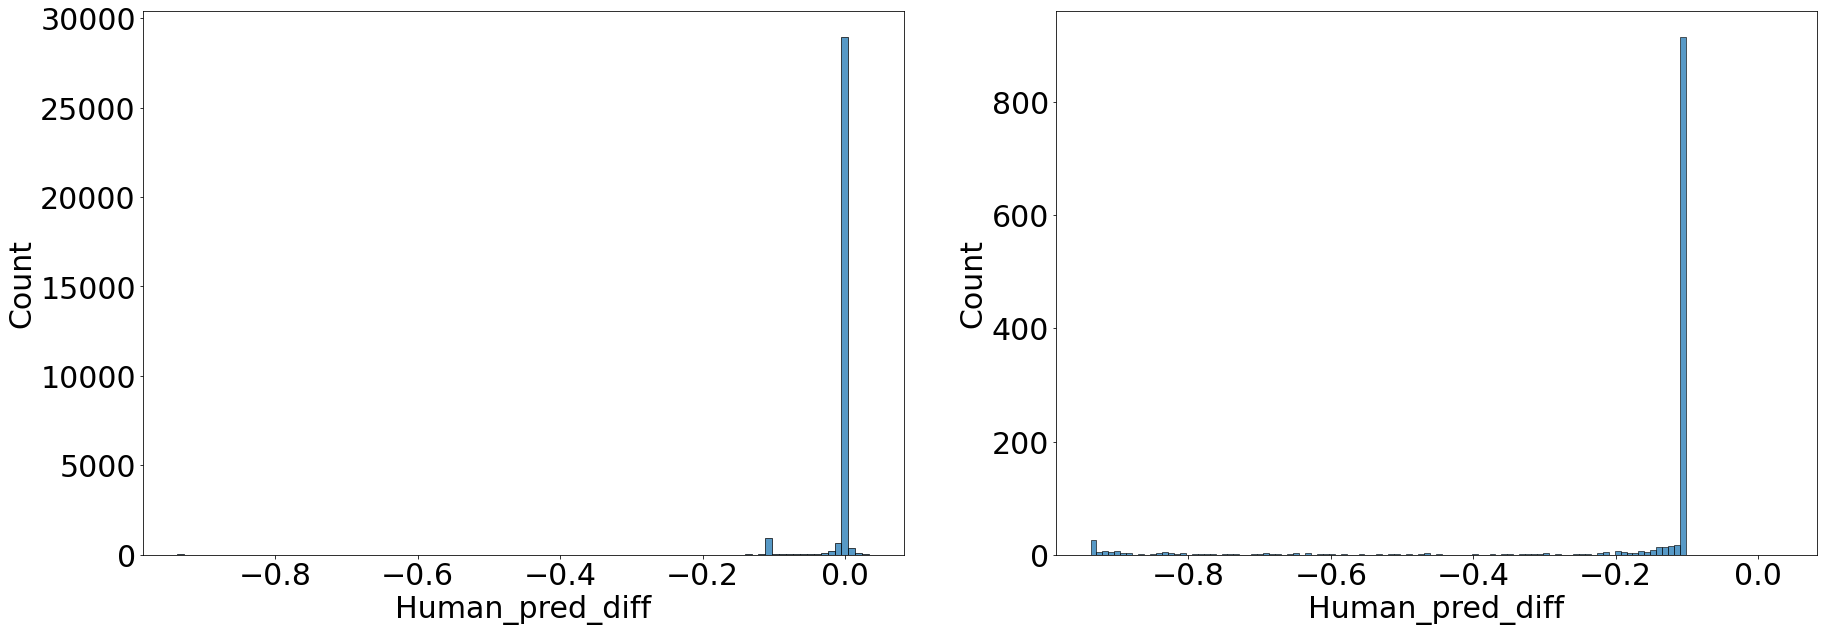

In [20]:
plt.clf()
plt.rcParams["xtick.labelsize"] = 30
plt.rcParams["ytick.labelsize"] = 30
plt.rcParams.update({'font.size': 30})
fig, axs = plt.subplots(1, 2, figsize=(30, 10), sharex=True, sharey=False)

sns.histplot(perturbed_output_df["Human_pred_diff"], bins=100, ax=axs[0])
sns.histplot(selected_df["Human_pred_diff"], bins=100, ax=axs[1])
plt.show()



### Distribution of Human pred diff in each position

<Figure size 432x288 with 0 Axes>

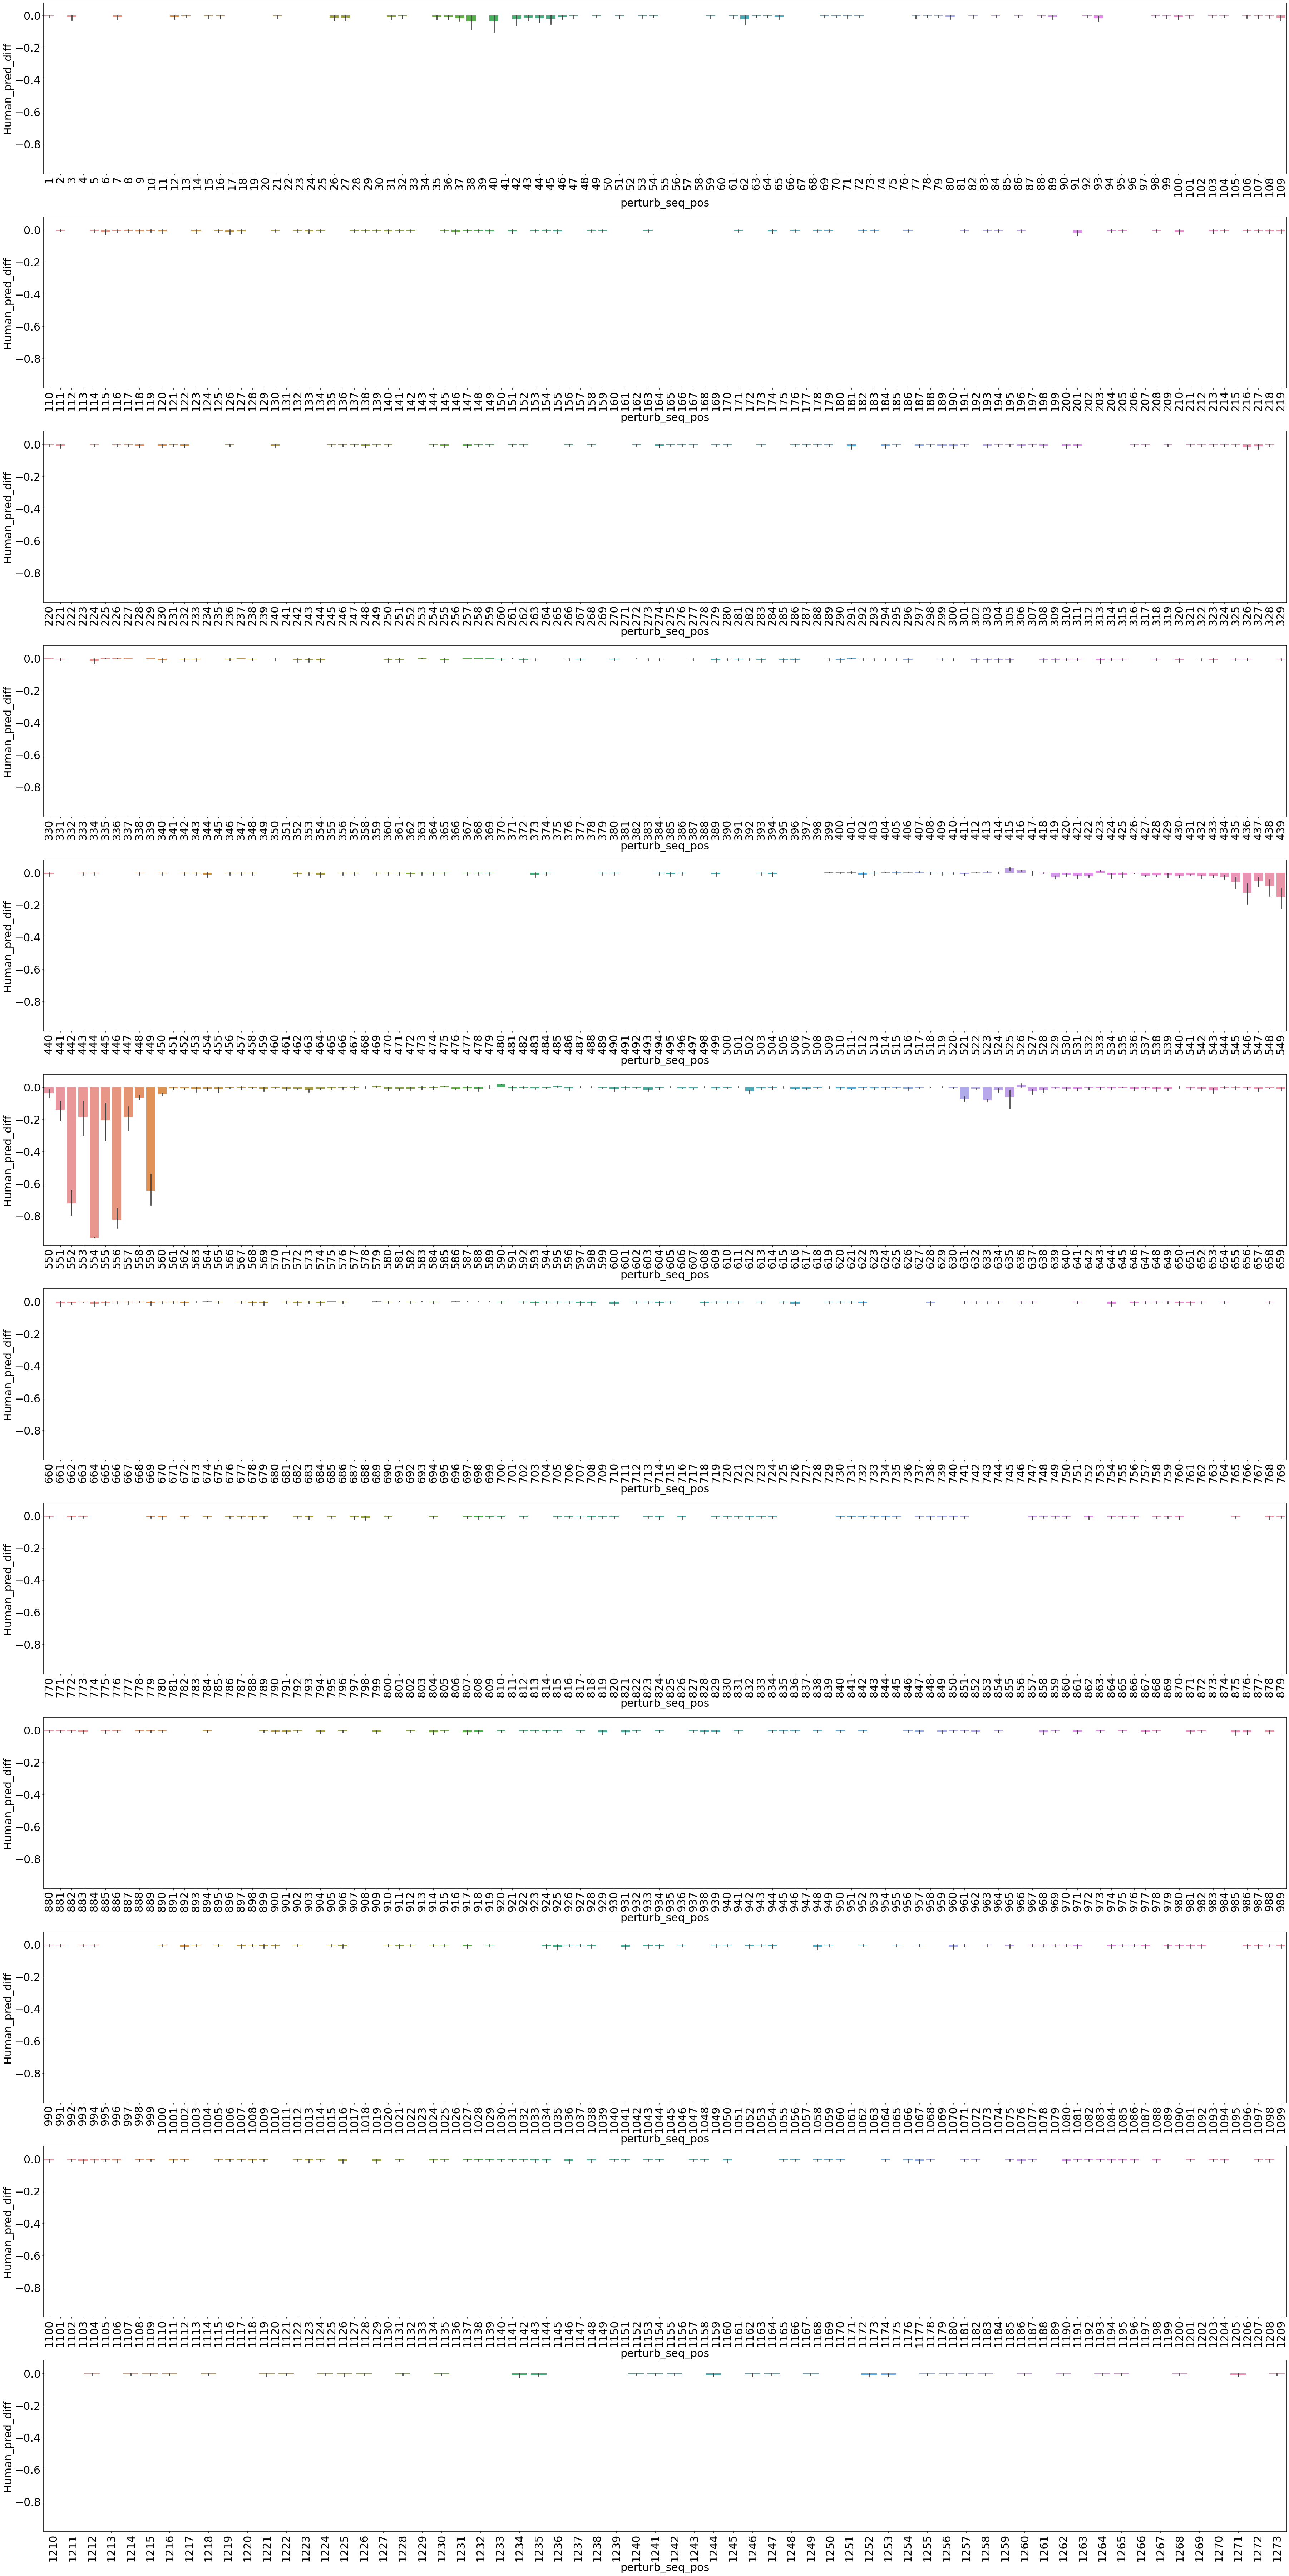

In [21]:
plt.clf()
plt.rcParams["xtick.labelsize"] = 30
plt.rcParams["ytick.labelsize"] = 30
plt.rcParams.update({'font.size': 30})
fig, axs = plt.subplots(12, 1, figsize=(50, 100), sharex=False, sharey=True)

j = 0
for i in range(0, 1274, 110):
    plot_df = perturbed_output_df[(perturbed_output_df["perturb_seq_pos"] >= i) & (perturbed_output_df["perturb_seq_pos"] < i+110)]
    sns.barplot(plot_df, x="perturb_seq_pos", y=pred_diff_col, ax=axs[j])
    axs[j].tick_params(axis='x', rotation=90)
    j += 1
    
plt.tight_layout(pad=.1)
plt.show()

# plt.clf()
# plt.figure(figsize=(70, 20))
# plt.rcParams["xtick.labelsize"] = 10
# plt.rcParams["ytick.labelsize"] = 10
# plt.rcParams.update({'font.size': 10})
# sns.barplot(perturbed_output_df, x="perturb_seq_pos", y=pred_diff_col)
# plt.xticks(rotation=90)
# plt.show()

### Cut-off: mean=0 and variance=0

In [24]:
mean_std_df = perturbed_output_df.groupby("perturb_seq_pos").agg(mean=(pred_diff_col, "mean"), std=(pred_diff_col, "std")).reset_index()
cut_off_pos = list(mean_std_df[(mean_std_df["mean"] == 0) & (mean_std_df["std"] == 0)]["perturb_seq_pos"].values)
cut_off_df_1 = perturbed_output_df[~perturbed_output_df["perturb_seq_pos"].isin(cut_off_pos)]
cut_off_df_1["perturb_seq_pos"].nunique()

1261

<Figure size 432x288 with 0 Axes>

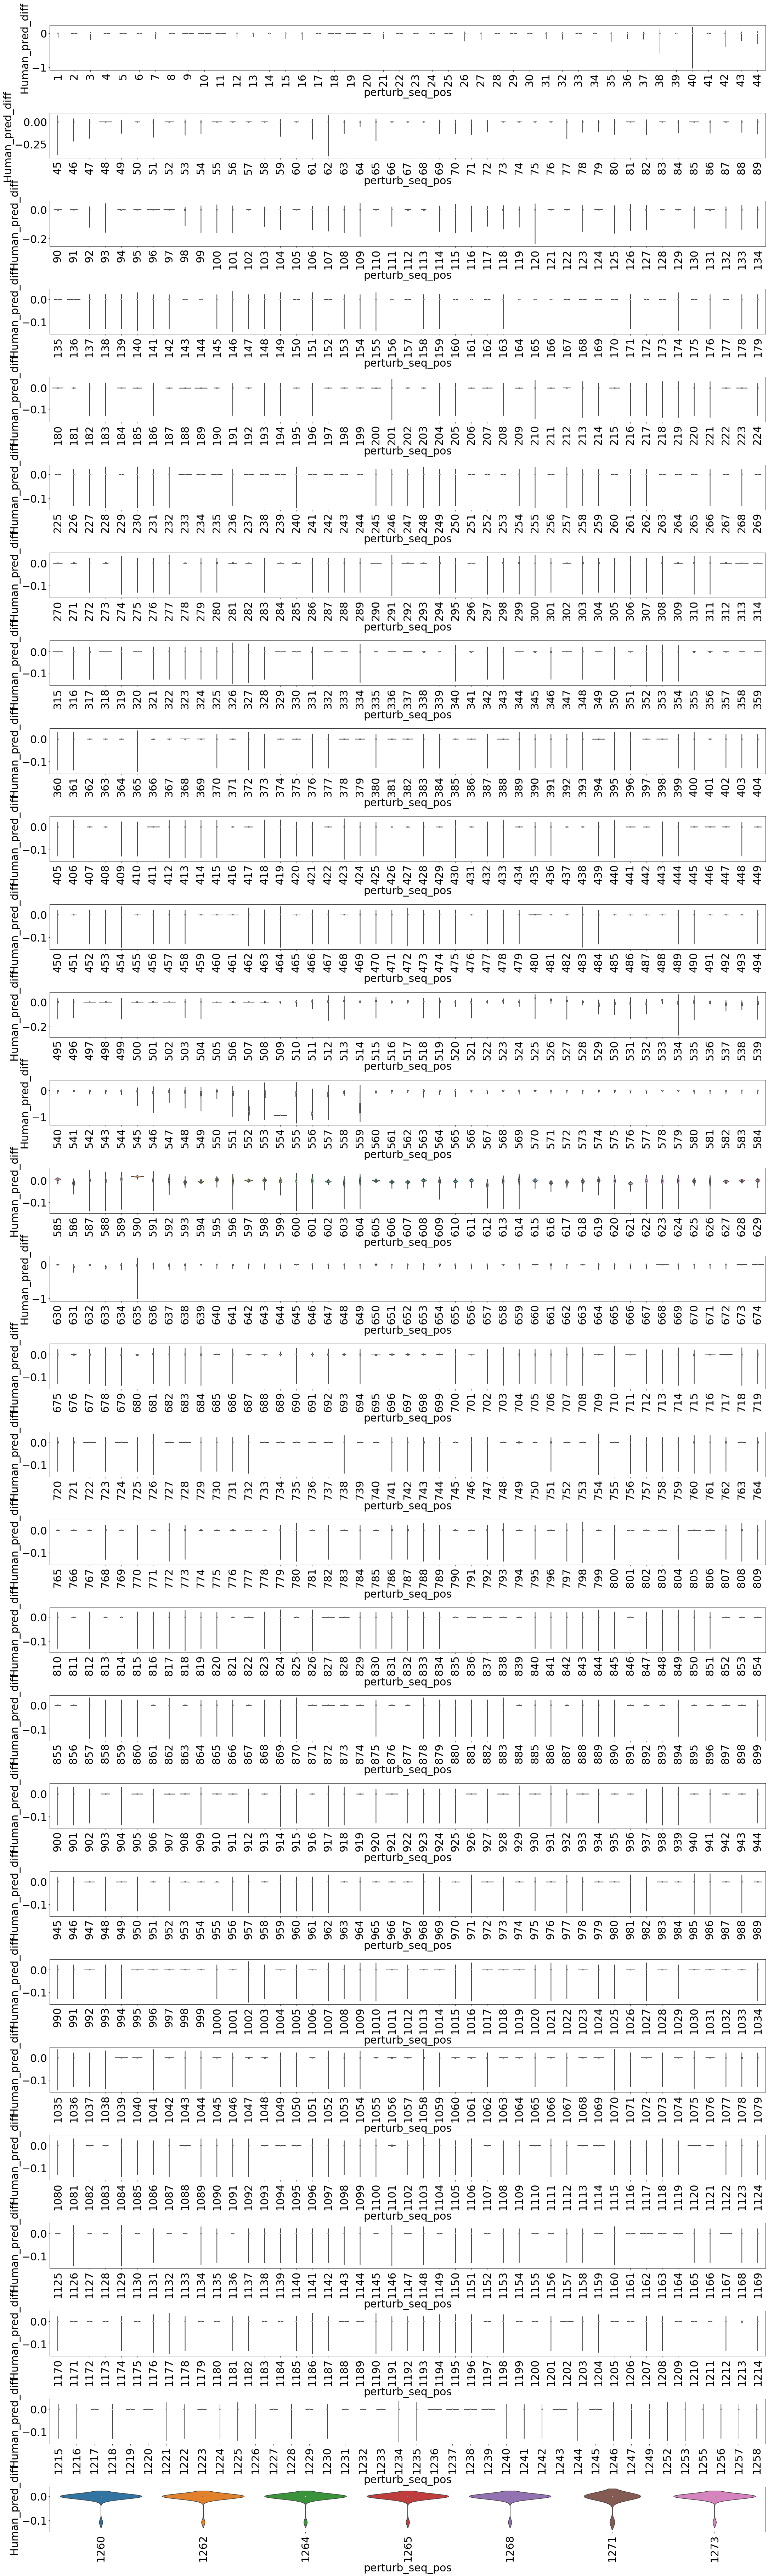

In [25]:
plt.clf()
plt.rcParams["xtick.labelsize"] = 30
plt.rcParams["ytick.labelsize"] = 30
plt.rcParams.update({'font.size': 30})
fig, axs = plt.subplots(29, 1, figsize=(30, 100), sharex=False, sharey=False)

j = 0
for i in range(0, 1273, 45):
    plot_df = cut_off_df_1[(cut_off_df_1["perturb_seq_pos"] >= i) & (cut_off_df_1["perturb_seq_pos"] < i+45)]
    sns.violinplot(plot_df, x="perturb_seq_pos", y=pred_diff_col, ax=axs[j])
    axs[j].tick_params(axis='x', rotation=90)
    j += 1
    
plt.tight_layout(pad=.1)
plt.show()

### Cut-off: abs_Human_pred_diff >= 0.1

In [26]:
cut_off_df_2 = perturbed_output_df[perturbed_output_df[f"abs_{pred_diff_col}"] >= 0.1]
cut_off_pos_1 = set(cut_off_df_1["perturb_seq_pos"].unique())
cut_off_pos_2 = set(cut_off_df_2["perturb_seq_pos"].unique())
print(f"1. Number of unique positions with mean !=0 and variance != 0 : {len(cut_off_pos_1)}")
print(f"2. Number of unique positions with abs_{pred_diff_col} > 0.1 : {len(cut_off_pos_2)}")

print(f"1 intersection 2: {len(cut_off_pos_1.intersection(cut_off_pos_2))}")
print(f"1 minus 2: {len(cut_off_pos_1 - cut_off_pos_2)}")
print(f"2 minus 1: {len(cut_off_pos_2 - cut_off_pos_1)}")
print(f"is 2 subset of 1: {cut_off_pos_2 <= cut_off_pos_1}")

1. Number of unique positions with mean !=0 and variance != 0 : 1261
2. Number of unique positions with abs_Human_pred_diff > 0.1 : 699
1 intersection 2: 699
1 minus 2: 562
2 minus 1: 0
is 2 subset of 1: True


In [27]:
import math

def get_uniformly_divided_position_bins(positions, n_bins):
    bin_width = math.floor(len(positions)/n_bins)
    bins = []
    start = 0
    for i in range(n_bins):
        end = start + bin_width
        bins.append(positions[start:end])
        start = end
    return bins

<Figure size 432x288 with 0 Axes>

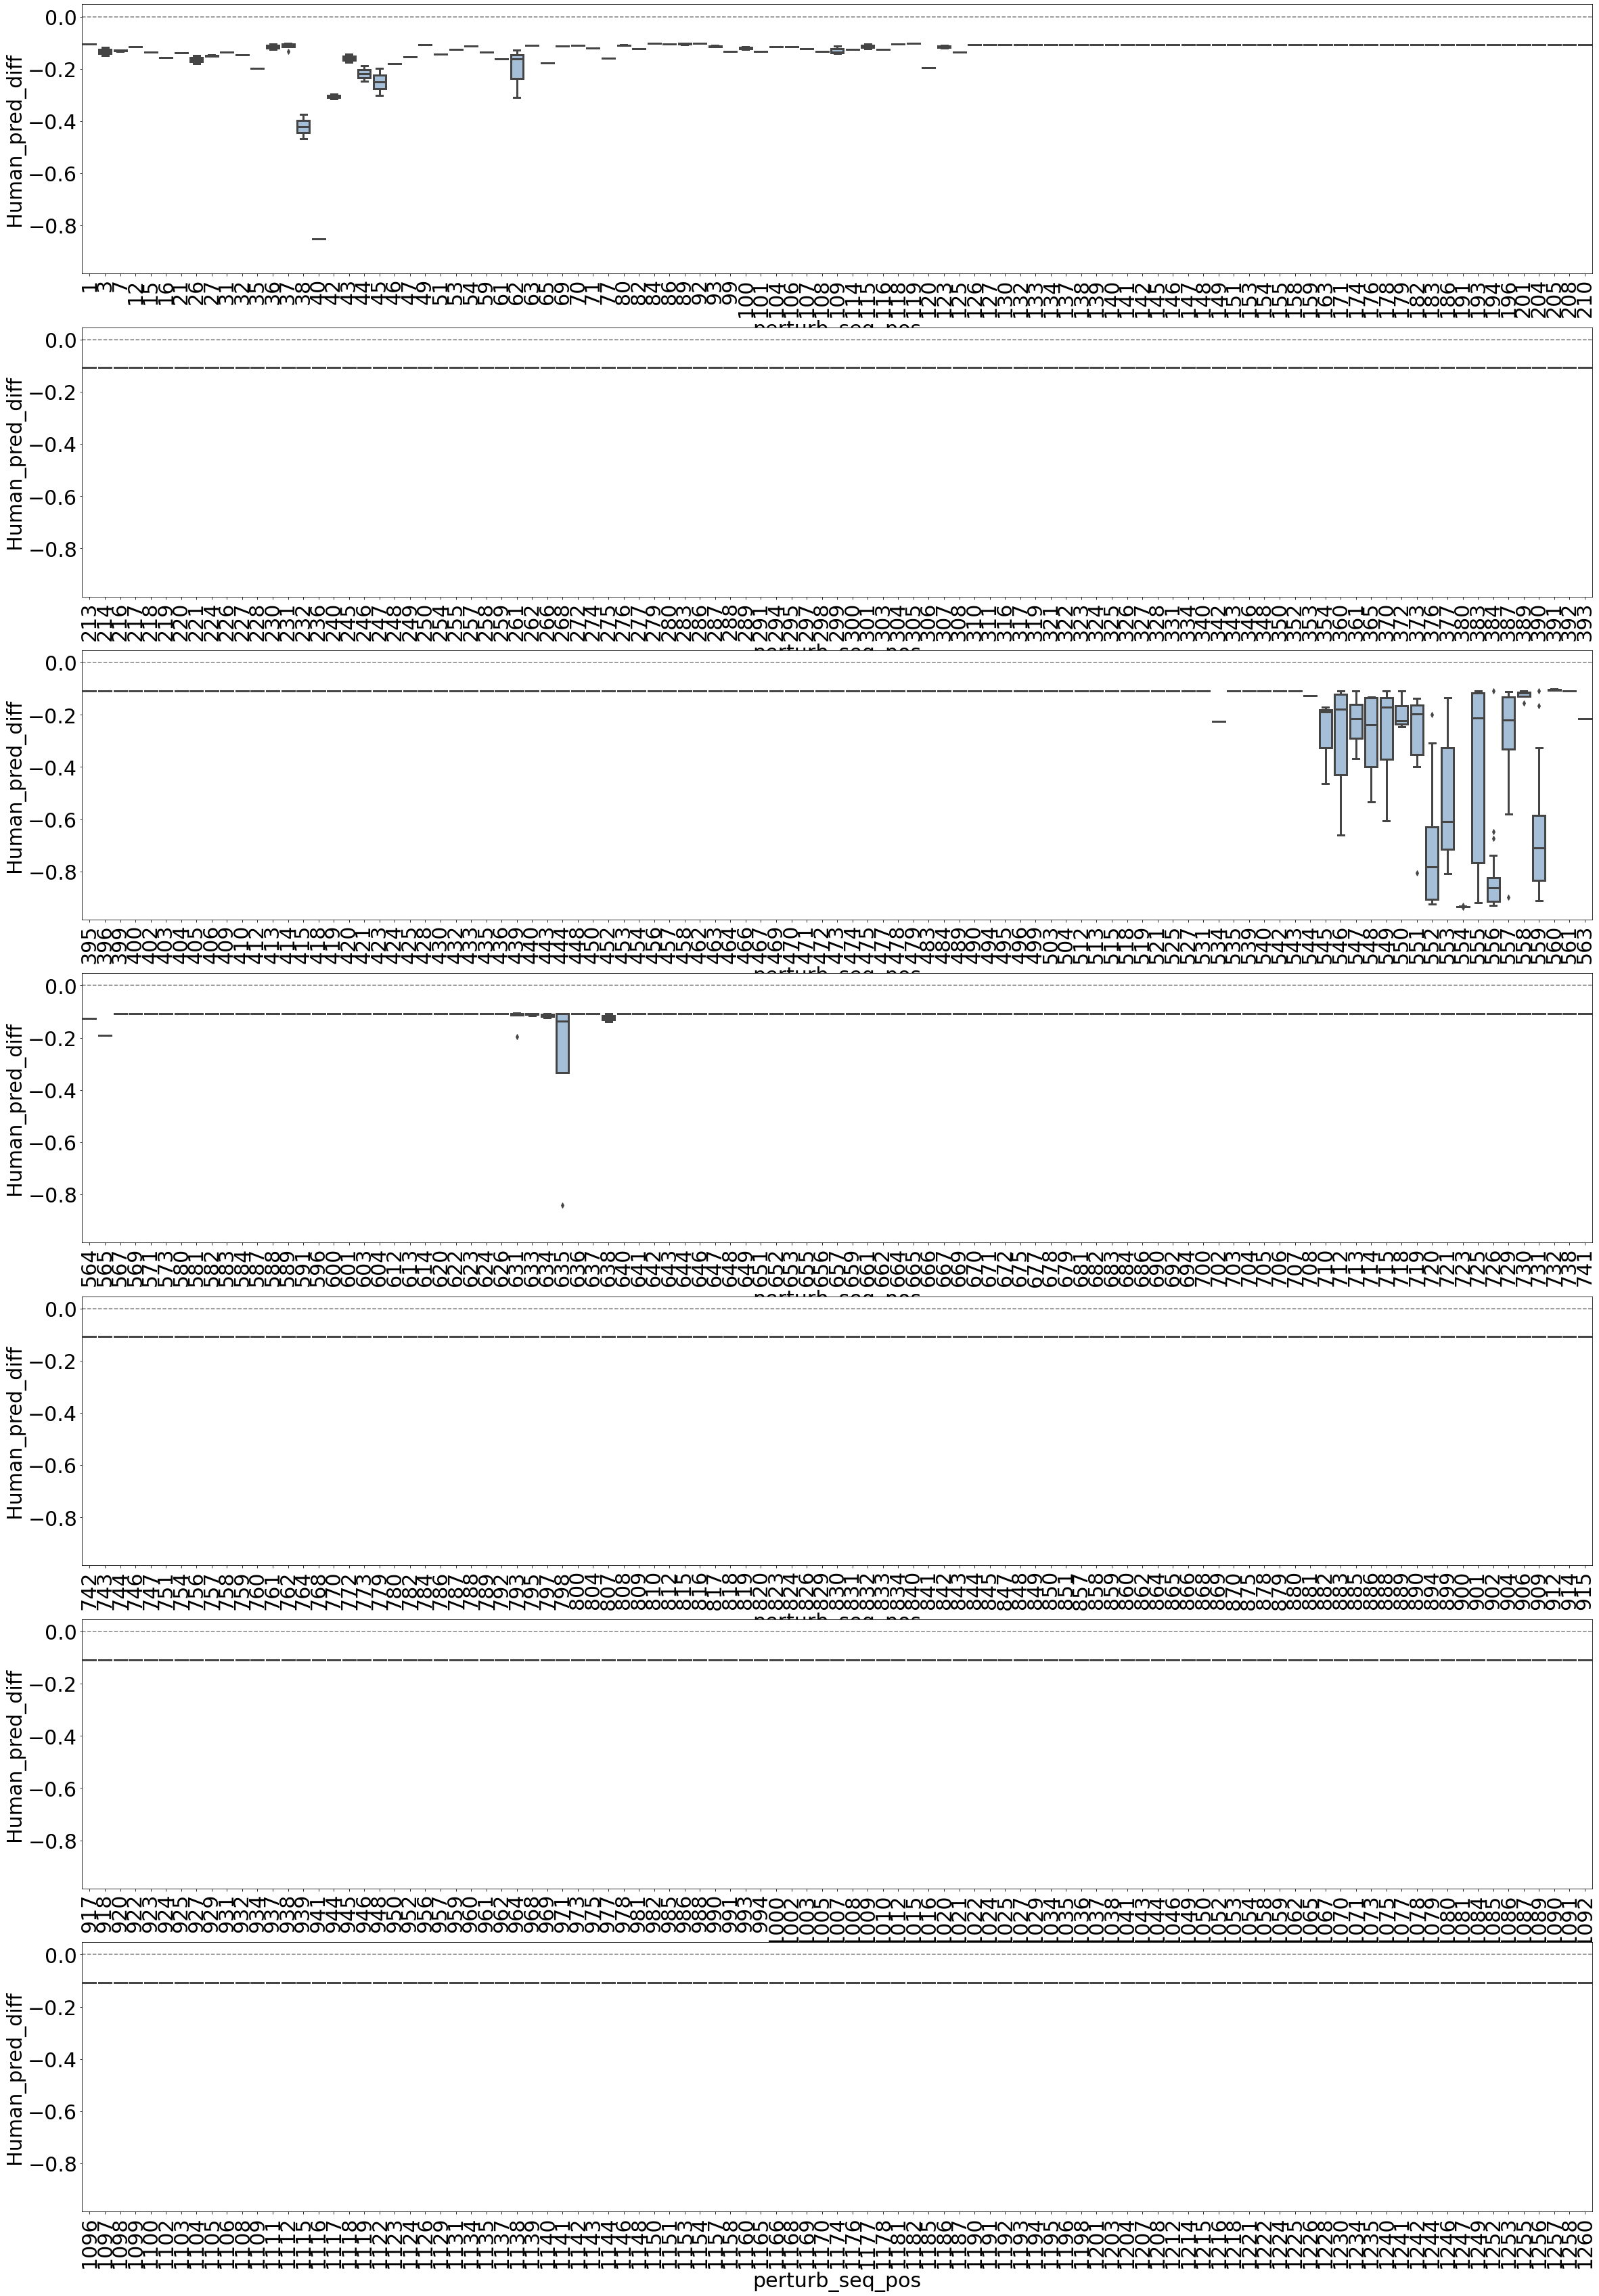

In [32]:
plt.clf()
fig, axs = plt.subplots(7, 1, figsize=(40, 60), sharey=True)
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30
plt.rcParams.update({'font.size': 30})

bins = get_uniformly_divided_position_bins(list(cut_off_pos_2), 7)

for i in range(7):
    sns.boxplot(data=cut_off_df_2[cut_off_df_2["perturb_seq_pos"].isin(bins[i])],  y="Human_pred_diff", x="perturb_seq_pos", ax=axs[i], orient="v", 
                linewidth=3,
                boxprops={"facecolor": (.3, .5, .7, .5)})
    axs[i].tick_params(axis='x', rotation=90)
    axs[i].axhline(0.0, color="gray", linestyle="--")

plt.show()


### Important positions causing class change from Human

109
22.93577981651376


<Figure size 432x288 with 0 Axes>

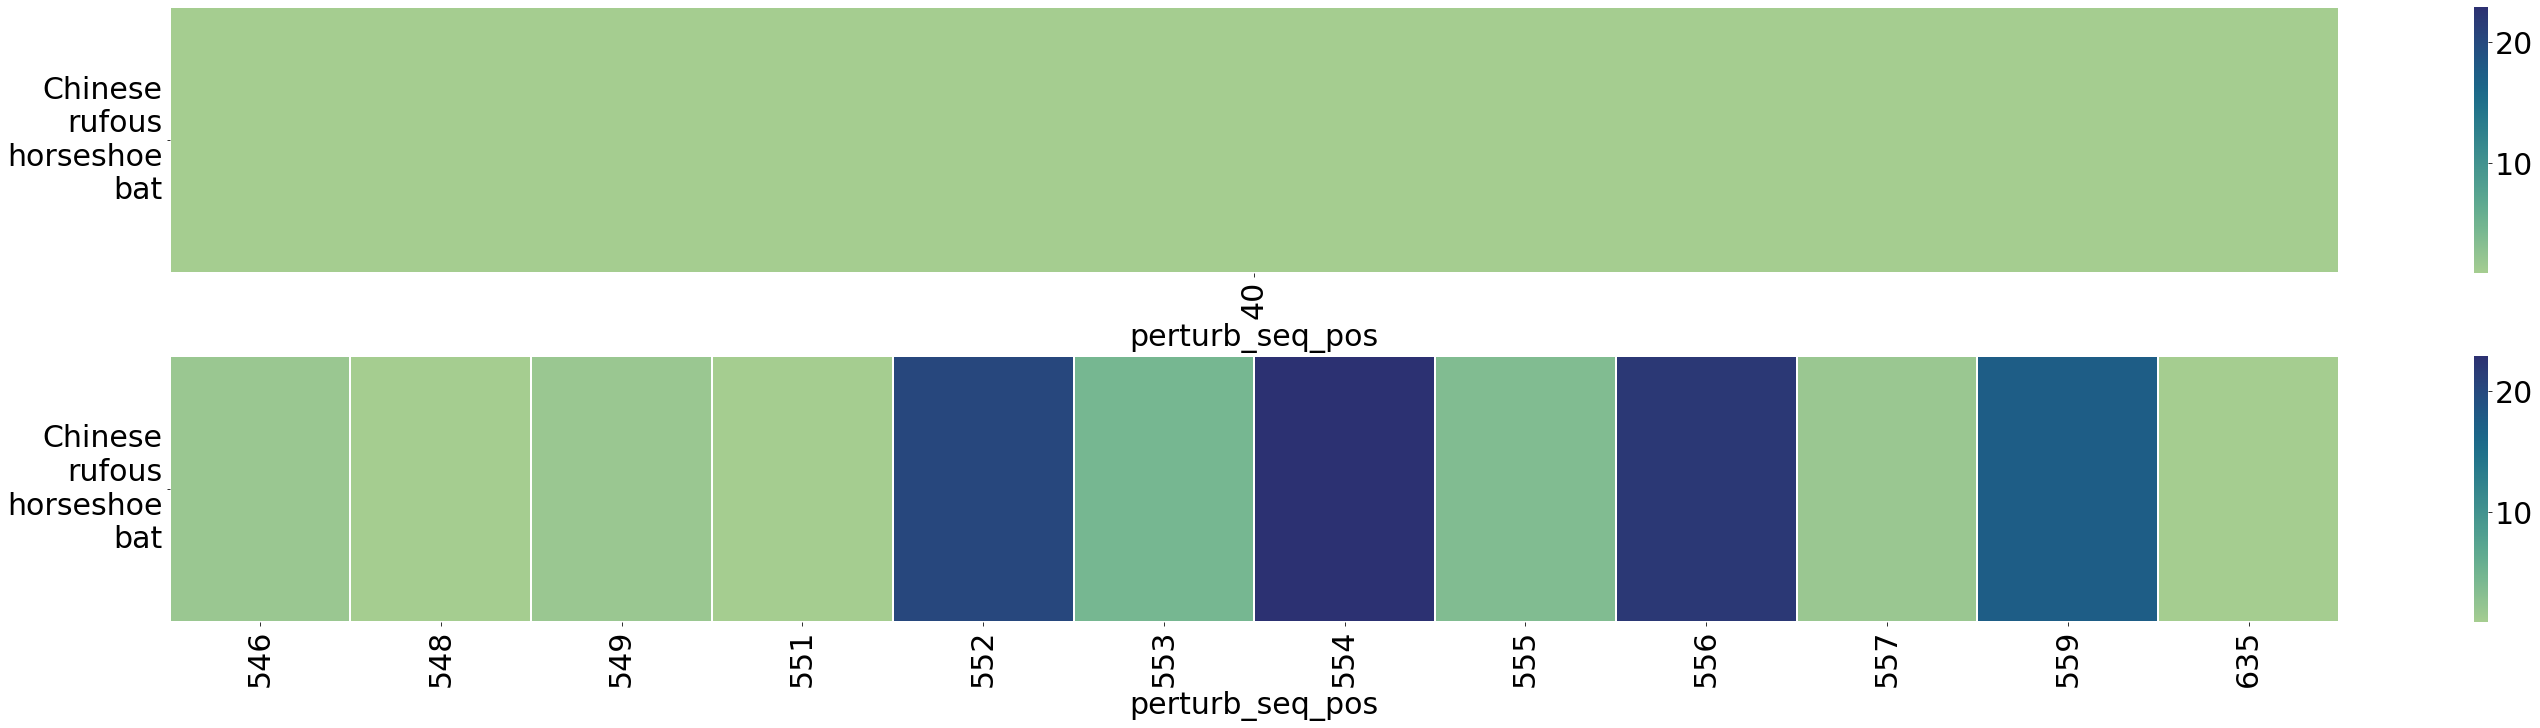

In [33]:
class_change_df = perturbed_output_df[(perturbed_output_df["orig_y_pred"] == "Human") & (perturbed_output_df["new_y_pred"] != "Human")]
n = class_change_df.shape[0]
print(n)
df = class_change_df[["uniref90_id", "perturb_seq_pos", "new_y_pred"]].groupby(["perturb_seq_pos", "new_y_pred"]).count().reset_index()
df["%"] = df["uniref90_id"]/n*100
max_val = df["%"].max()
print(max_val)
df = df.pivot(index="perturb_seq_pos", columns="new_y_pred", values="%")
df.columns.name = None
df = df.reset_index()
# df.drop(["new_y_pred"], axis=1, inplace=True)

plt.clf()
fig, axs = plt.subplots(2, 1, figsize=(40, 10), sharey=True)
plt.rcParams.update({'font.size': 30})
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30

sns.heatmap(data=df[df["perturb_seq_pos"] <=250].set_index("perturb_seq_pos").T, linewidth=.1, cmap="crest", ax=axs[0], vmax=max_val)
wrap_yticklabels(axs[0], label_width=10, break_long_words=True)
axs[0].tick_params(axis='x', rotation=90)


sns.heatmap(data=df[df["perturb_seq_pos"] > 250].set_index("perturb_seq_pos").T, linewidth=.1, cmap="crest", ax=axs[1], vmax=max_val)
wrap_yticklabels(axs[1], label_width=10, break_long_words=True)
axs[1].tick_params(axis='x', rotation=90)
plt.tight_layout(pad=.1)
plt.show()


### Important positions causing class change from Human due to difference >= 0.1

109


<Figure size 432x288 with 0 Axes>

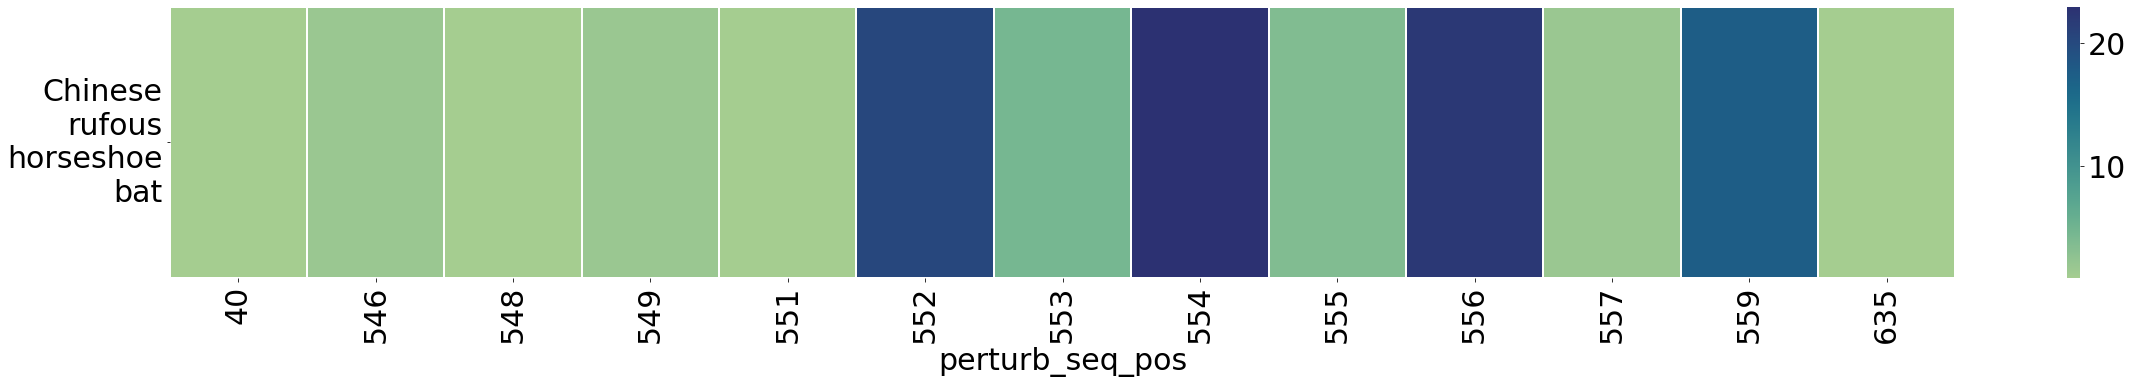

In [34]:
class_change_df = cut_off_df_2[(cut_off_df_2["orig_y_pred"] == "Human") & (cut_off_df_2["new_y_pred"] != "Human")]
n = class_change_df.shape[0]
print(n)
df = class_change_df[["uniref90_id", "perturb_seq_pos", "new_y_pred"]].groupby(["perturb_seq_pos", "new_y_pred"]).count().reset_index()
df["%"] = df["uniref90_id"]/n*100
df = df.pivot(index="perturb_seq_pos", columns="new_y_pred", values="%")
df.columns.name = None
# df.drop(["new_y_pred"], axis=1, inplace=True)
plt.clf()
plt.figure(figsize=(40, 5))
plt.rcParams.update({'font.size': 30})
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30

ax = sns.heatmap(data=df.T, linewidth=.1, cmap="crest")
wrap_yticklabels(ax, label_width=10, break_long_words=True)
ax.tick_params(axis='x', rotation=90)
plt.show()

## Identified important mutations
**Cut-off: abs_Human_pred_diff >= 0.1**

### Mutations with new token=X

In [35]:
cut_off_df_2["perturbation_id"] = cut_off_df_2["orig_token"] + cut_off_df_2["perturb_seq_pos"].astype("str") + cut_off_df_2["new_token"]
x_mutation_df = cut_off_df_2[cut_off_df_2["new_token"] == "X"]
non_x_mutation_df = cut_off_df_2[cut_off_df_2["new_token"] != "X"].copy()

/tmp/ipykernel_402400/3113693862.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cut_off_df_2["perturbation_id"] = cut_off_df_2["orig_token"] + cut_off_df_2["perturb_seq_pos"].astype("str") + cut_off_df_2["new_token"]


In [ ]:
#!pip install textalloc


<Figure size 432x288 with 0 Axes>

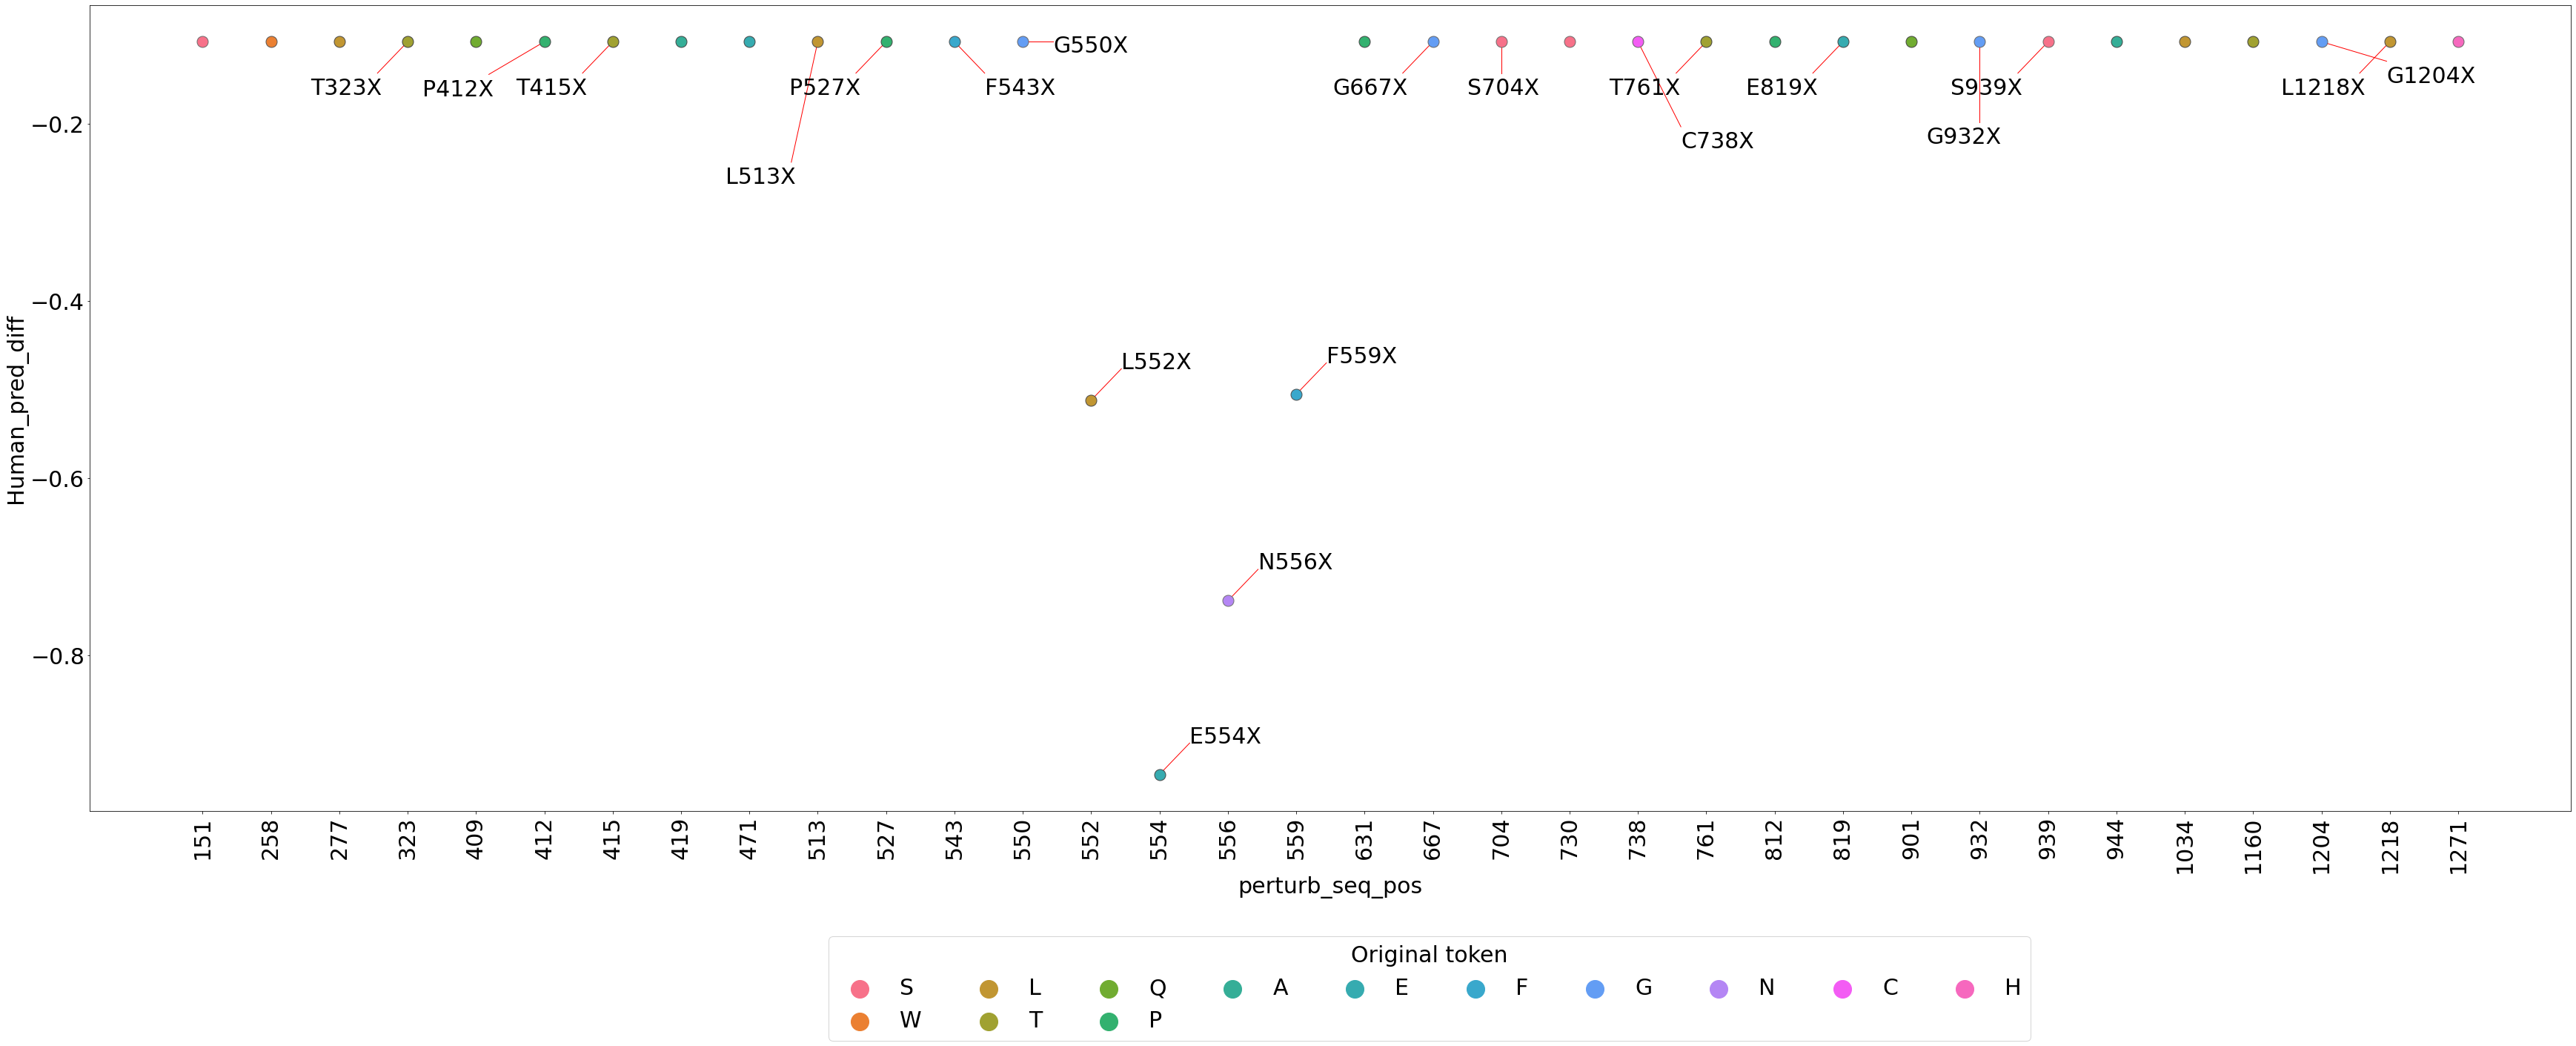

In [36]:
import textalloc as ta
plt.clf()
plt.figure(figsize=(60, 20))
plt.rcParams.update({'font.size': 30})
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30
annotate_df = x_mutation_df.sort_values(f"abs_{pred_diff_col}", ascending=False)[:20]
ax = sns.stripplot(data=x_mutation_df, y="Human_pred_diff", x="perturb_seq_pos", hue="orig_token", orient="v", s=15, linewidth=1)
ax.figure.canvas.draw()
x_mapping = {}
plt.legend(bbox_to_anchor=(.8, -0.1), borderaxespad=2.0, markerscale=4., ncol=10, title="Original token")
ax.tick_params(axis='x', rotation=90)
for i in ax.get_xticklabels():
    x_mapping[str(i.get_text())] = i.get_position()[0]
text_list = list(annotate_df["perturbation_id"].values)
x = []
y = []
for _, row in annotate_df.iterrows():
    x.append(x_mapping[str(row["perturb_seq_pos"])])
    y.append(row["Human_pred_diff"])
ta.allocate(ax, x, y, text_list, 
            x_scatter=[x_mapping[str(i)] for i in x_mutation_df["perturb_seq_pos"].values], 
            y_scatter=x_mutation_df[pred_diff_col].values, textsize=30)
plt.show()

In [37]:
annotate_df

Cat   Chicken  Chinese rufous horseshoe bat    Ferret  \
5073   0.000002  0.000001                      0.714015  0.000028   
9133   0.000009  0.000005                      0.632233  0.000015   
19672  0.000016  0.000007                      0.451663  0.000013   
1706   0.000013  0.000005                      0.449308  0.000010   
288    0.002760  0.000763                      0.110685  0.000500   
23296  0.002760  0.000763                      0.110685  0.000500   
21248  0.002760  0.000763                      0.110685  0.000500   
21568  0.002760  0.000763                      0.110685  0.000500   
22016  0.002760  0.000763                      0.110685  0.000500   
23232  0.002760  0.000763                      0.110685  0.000500   
24832  0.002760  0.000763                      0.110685  0.000500   
24352  0.002760  0.000763                      0.110685  0.000500   
25856  0.002760  0.000763                      0.110685  0.000500   
26816  0.002760  0.000763                      0.110685  0.000500   
27360  0.002760  0.000763                      0.110685  0.000500   
29632  0.002760  0.000763                      0.110685  0.000500   
31456  0.002760  0.000763                      0.110685  0.000500   
20576  0.002760  0.000763                      0.110685  0.000500   
17632  0.002760  0.000763                      0.110685  0.000500   
18656  0.002760  0.000763                      0.110685  0.000500   

          Gray wolf  Horshoe bat     Human       Pig uniref90_id y_true  \
5073   5.108603e-07     0.269309  0.016290  0.000354       WIV04  Human   
9133   8.914528e-06     0.155334  0.212322  0.000074       WIV04  Human   
19672  2.184987e-05     0.109462  0.438764  0.000054       WIV04  Human   
1706   1.745837e-05     0.105158  0.445445  0.000043       WIV04  Human   
288    5.276843e-03     0.035618  0.843437  0.000960       WIV04  Human   
23296  5.276843e-03     0.035618  0.843437  0.000960       WIV04  Human   
21248  5.276843e-03     0.035618  0.843437  0.000960       WIV04  Human   
21568  5.276843e-03     0.035618  0.843437  0.000960       WIV04  Human   
22016  5.276843e-03     0.035618  0.843437  0.000960       WIV04  Human   
23232  5.276843e-03     0.035618  0.843437  0.000960       WIV04  Human   
24832  5.276843e-03     0.035618  0.843437  0.000960       WIV04  Human   
24352  5.276843e-03     0.035618  0.843437  0.000960       WIV04  Human   
25856  5.276843e-03     0.035618  0.843437  0.000960       WIV04  Human   
26816  5.276843e-03     0.035618  0.843437  0.000960       WIV04  Human   
27360  5.276843e-03     0.035618  0.843437  0.000960       WIV04  Human   
29632  5.276843e-03     0.035618  0.843437  0.000960       WIV04  Human   
31456  5.276843e-03     0.035618  0.843437  0.000960       WIV04  Human   
20576  5.276843e-03     0.035618  0.843437  0.000960       WIV04  Human   
17632  5.276843e-03     0.035618  0.843437  0.000960       WIV04  Human   
18656  5.276843e-03     0.035618  0.843437  0.000960       WIV04  Human   

      orig_token  perturb_pos new_token  Human_pred_diff  abs_Human_pred_diff  \
5073           E         1511         X        -0.934703             0.934703   
9133           N         1513         X        -0.738671             0.738671   
19672          L         1509         X        -0.512229             0.512229   
1706           F         1516         X        -0.505548             0.505548   
288            E         1857         X        -0.107556             0.107556   
23296          P         1484         X        -0.107556             0.107556   
21248          L         2320         X        -0.107556             0.107556   
21568          T         1768         X        -0.107556             0.107556   
22016          T         1101         X        -0.107556             0.107556   
23232          T          791         X        -0.107556             0.107556   
24832          F         1500         X        -0.107556             0.107556   
24352         

### Mutations with new token NOT = X

In [38]:
print(f"New token != X = {non_x_mutation_df.shape}")
print(f"Number of unique mutations = {non_x_mutation_df['perturbation_id'].nunique()}")
annotate_df_pos = non_x_mutation_df.sort_values(by="Human_pred_diff", axis=0, ascending=False)[:10]
annotate_df_neg = non_x_mutation_df.sort_values("Human_pred_diff", axis=0)[:10]
annotate_df = pd.concat([annotate_df_pos, annotate_df_neg])

New token != X = (1123, 19)
Number of unique mutations = 1123


<Figure size 432x288 with 0 Axes>

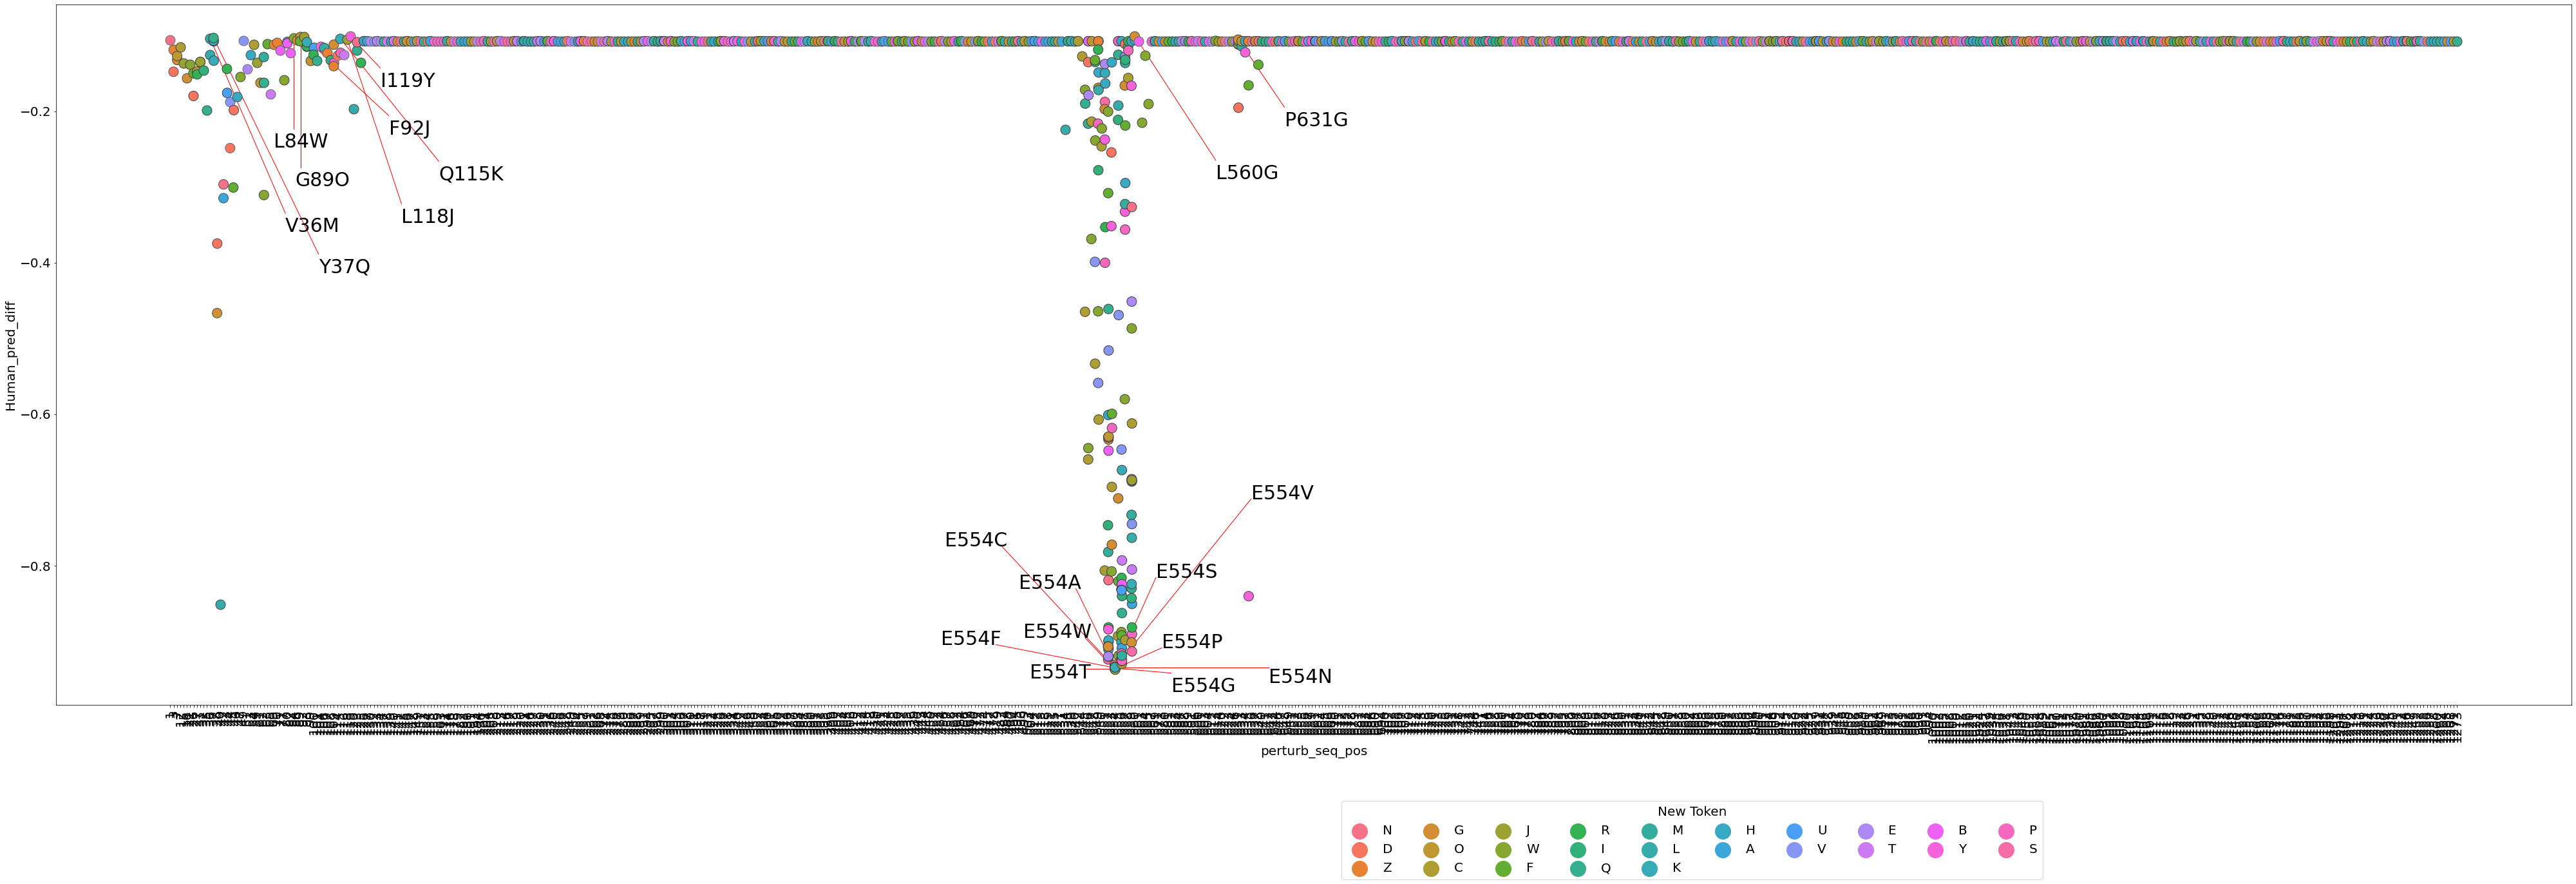

In [43]:
plt.clf()
plt.figure(figsize=(70, 20))
plt.rcParams.update({'font.size': 20})
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20

ax = sns.stripplot(data=non_x_mutation_df, x="perturb_seq_pos", y="Human_pred_diff", hue="new_token", orient="v", s=15, linewidth=1)
ax.figure.canvas.draw()
plt.legend(bbox_to_anchor=(.8, -0.1), borderaxespad=2.0, markerscale=4., ncol=10, title="New Token")
ax.tick_params(axis='x', rotation=90)

x_mapping = {}

for i in ax.get_xticklabels():
    x_mapping[str(i.get_text())] = i.get_position()[0]

text_list = list(annotate_df["perturbation_id"].values)
x = []
y = []
for _, row in annotate_df.iterrows():
    x.append(x_mapping[str(row["perturb_seq_pos"])])
    y.append(row["Human_pred_diff"])

ta.allocate(ax, x, y, text_list, 
            x_scatter=[x_mapping[str(i)] for i in non_x_mutation_df["perturb_seq_pos"].values], 
            y_scatter=non_x_mutation_df[pred_diff_col].values, textsize=30)
plt.show()

In [44]:
cut_off_df_2["perturbation_id"].nunique()

1157

<Figure size 432x288 with 0 Axes>

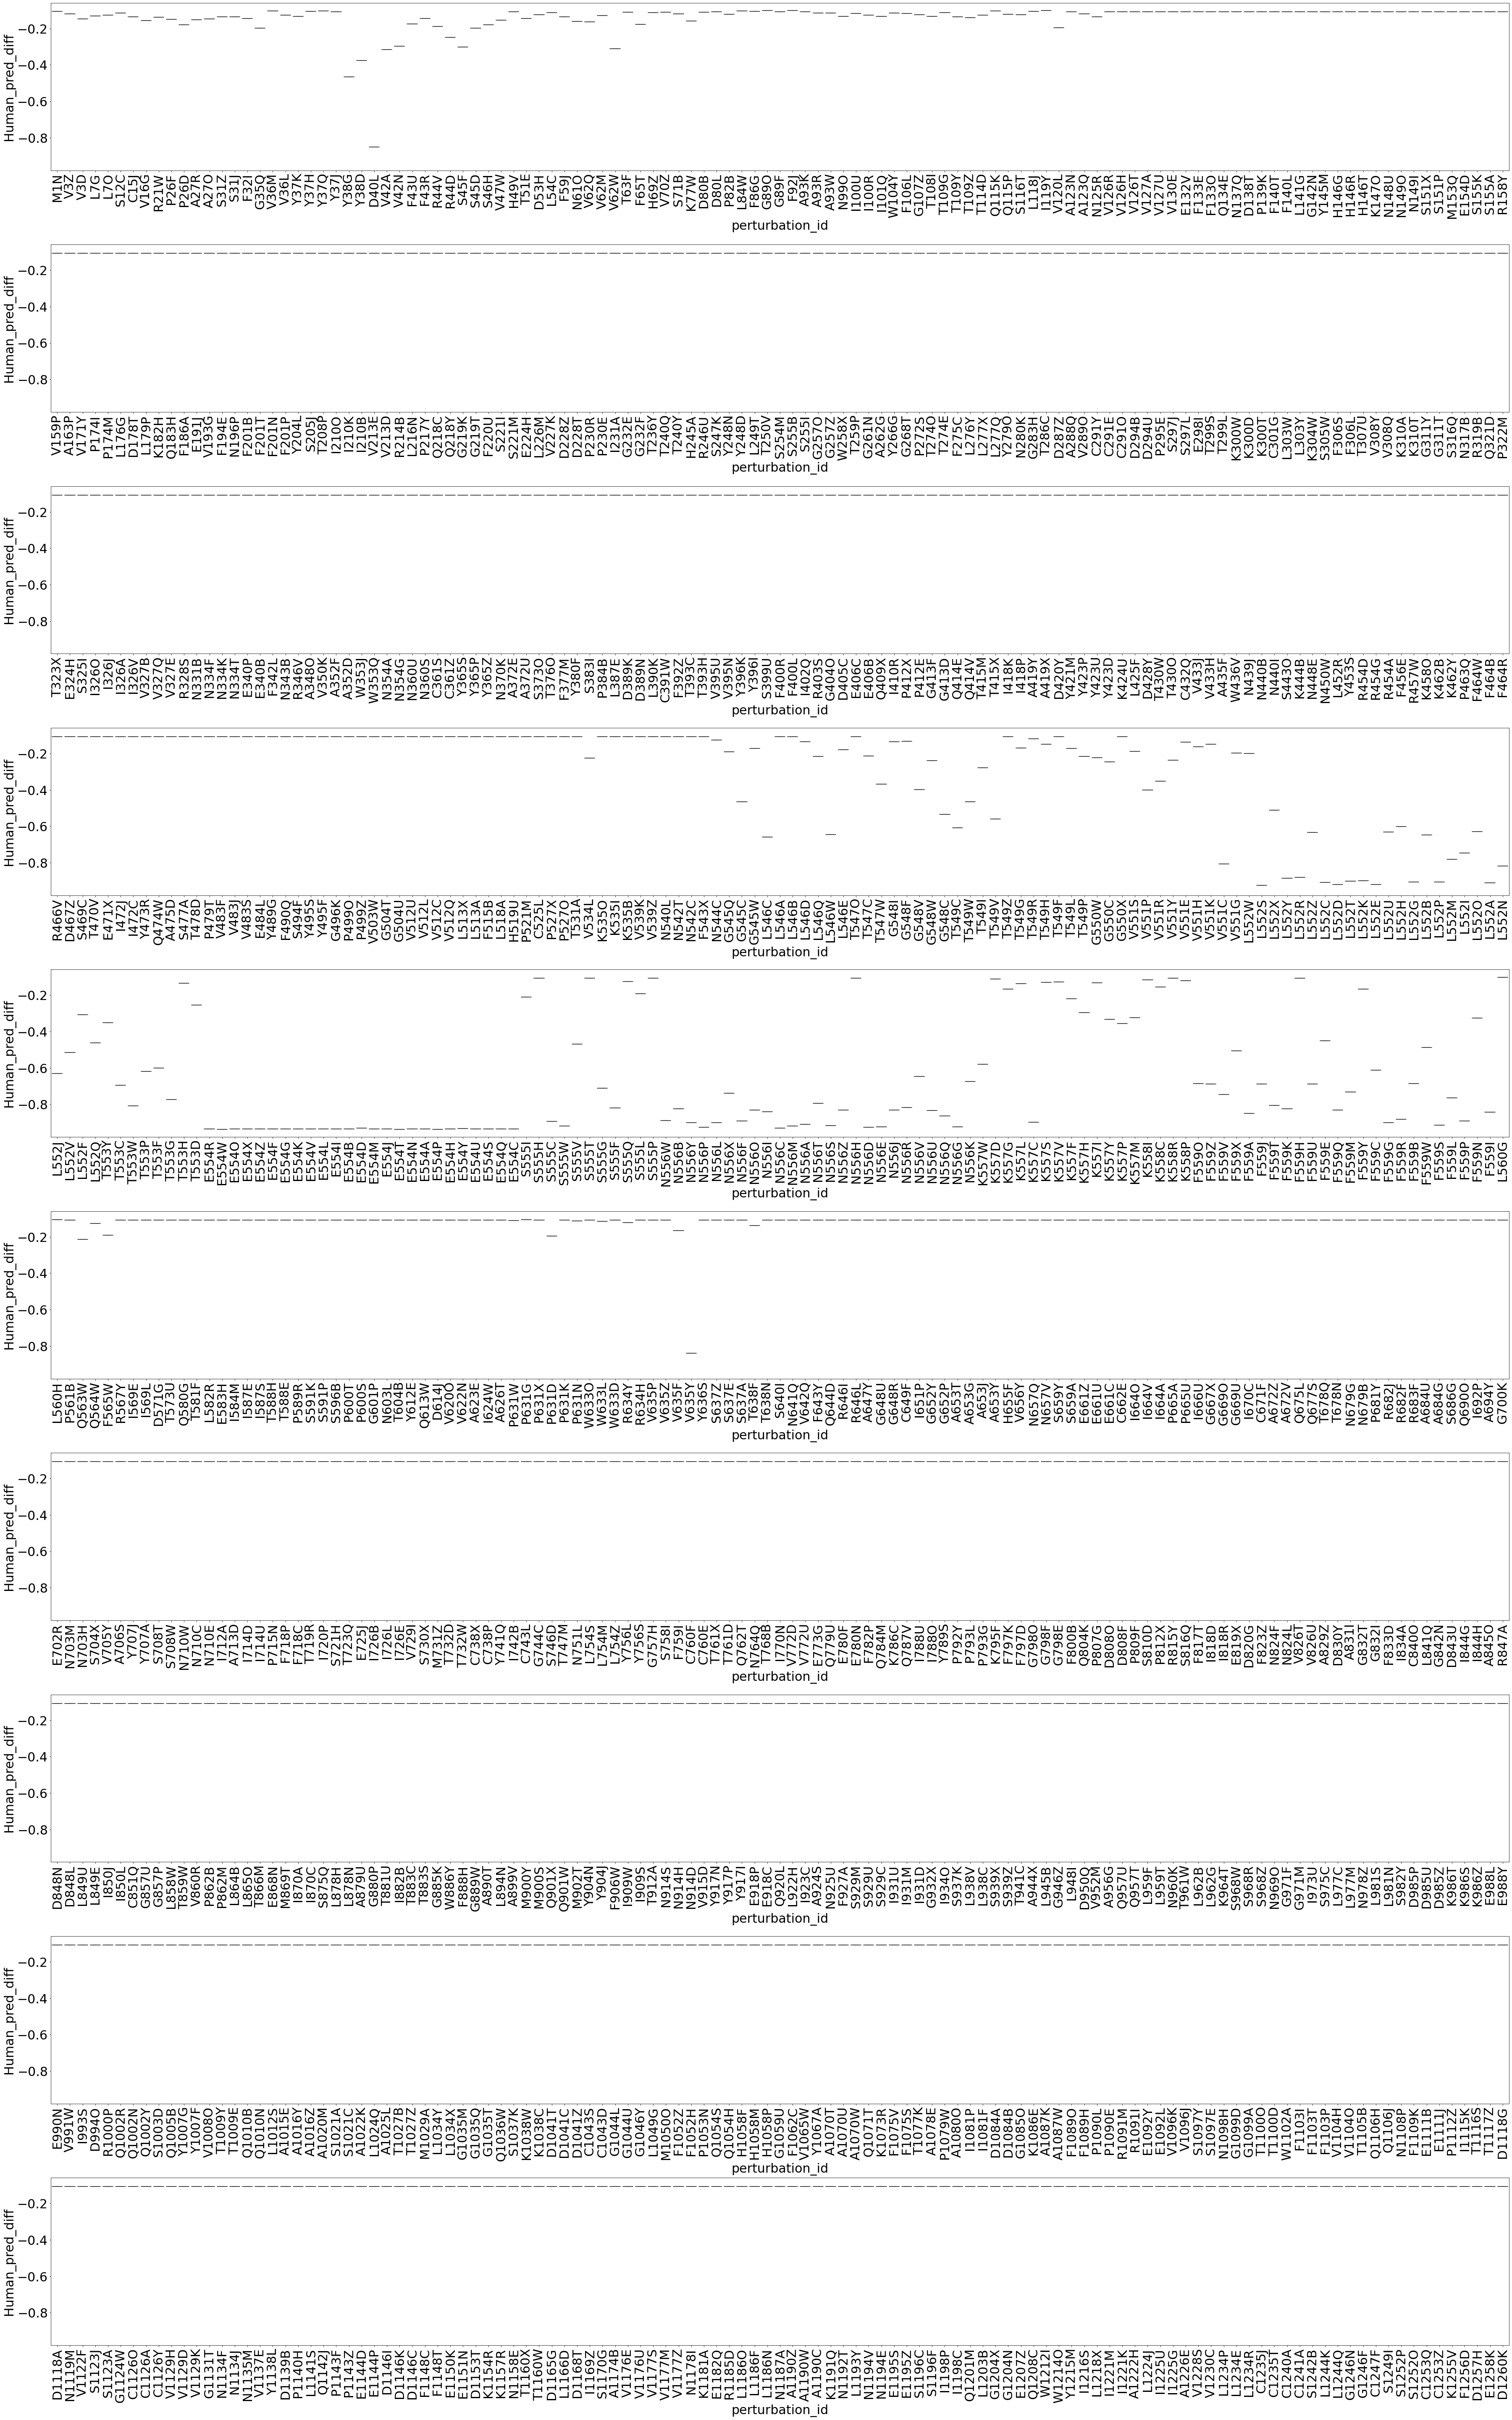

In [55]:
plt.clf()
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30
plt.rcParams.update({'font.size': 30})

perturbation_ids = cut_off_df_2.sort_values("perturb_seq_pos")["perturbation_id"].unique()
fig, axs = plt.subplots(10, 1, figsize=(50, 80), sharex=False, sharey=True)

bins = get_uniformly_divided_position_bins(list(perturbation_ids), 10)

j = 0
for i in range(10):
    plot_df = cut_off_df_2[cut_off_df_2["perturbation_id"].isin(bins[i])]
    sns.boxplot(plot_df, x="perturbation_id", y=pred_diff_col, ax=axs[j], orient="v", order=bins[i],
               boxprops={"facecolor": (.3, .5, .7, .5)})
    axs[j].tick_params(axis='x', rotation=90)
    j += 1
    
plt.tight_layout(pad=.2)
plt.show()

## Known Mutations

In [47]:
s_mutations_file_path = os.path.join(os.getcwd(), "..", "..", "..", "..", "..", "input/data/coronaviridae/20240313/wiv04/s_mutations.csv")
s_mutations_df = pd.read_csv(s_mutations_file_path)
s_mutations_df["perturbation_id"] = s_mutations_df["orig_token"] + s_mutations_df["pos"].astype("str") + s_mutations_df["new_token"]
s_mutations_df

orig_token  pos new_token perturbation_id
0           D  614         G           D614G
1           S  943         P           S943P
2           E  484         K           E484K
3           N  501         Y           N501Y
4           L  452         R           L452R
5           Q  677         P           Q677P
6           Q  677         H           Q677H
7           P  681         H           P681H
8           E  484         Q           E484Q
9           K  417         N           K417N
10          K  417         T           K417T
11          S  477         G           S477G
12          S  477         N           S477N

In [48]:
perturbed_output_df["perturbation_id"] = perturbed_output_df.apply(lambda x: f"{x['orig_token']}{x['perturb_seq_pos']}{x['new_token']}", axis=1)

In [49]:
known_mutations_df = perturbed_output_df[perturbed_output_df["perturbation_id"].isin(s_mutations_df["perturbation_id"])]
known_mutations_stats = known_mutations_df[["uniref90_id", "perturbation_id"]].groupby("perturbation_id").count().reset_index()
known_mutations_stats.rename(columns={"uniref90_id": "n_unique_sequences"}, inplace=True)
known_mutations_stats["percentage"] = known_mutations_stats["n_unique_sequences"] / 94 * 100
known_mutations_stats["label"] = known_mutations_stats.apply(lambda x: f"{x['perturbation_id']} (n={x['n_unique_sequences']} | {format(x['percentage'], '.2f')}%)", axis=1)
known_mutations_df = known_mutations_df.merge(known_mutations_stats[["perturbation_id", "label"]], on="perturbation_id")

s_mutations_df = s_mutations_df.merge(known_mutations_stats[["perturbation_id", "label"]], on="perturbation_id")
s_mutations_df

orig_token  pos new_token perturbation_id                label
0           D  614         G           D614G  D614G (n=1 | 1.06%)
1           S  943         P           S943P  S943P (n=1 | 1.06%)
2           E  484         K           E484K  E484K (n=1 | 1.06%)
3           N  501         Y           N501Y  N501Y (n=1 | 1.06%)
4           L  452         R           L452R  L452R (n=1 | 1.06%)
5           Q  677         P           Q677P  Q677P (n=1 | 1.06%)
6           Q  677         H           Q677H  Q677H (n=1 | 1.06%)
7           P  681         H           P681H  P681H (n=1 | 1.06%)
8           E  484         Q           E484Q  E484Q (n=1 | 1.06%)
9           K  417         N           K417N  K417N (n=1 | 1.06%)
10          K  417         T           K417T  K417T (n=1 | 1.06%)
11          S  477         G           S477G  S477G (n=1 | 1.06%)
12          S  477         N           S477N  S477N (n=1 | 1.06%)

<Figure size 432x288 with 0 Axes>

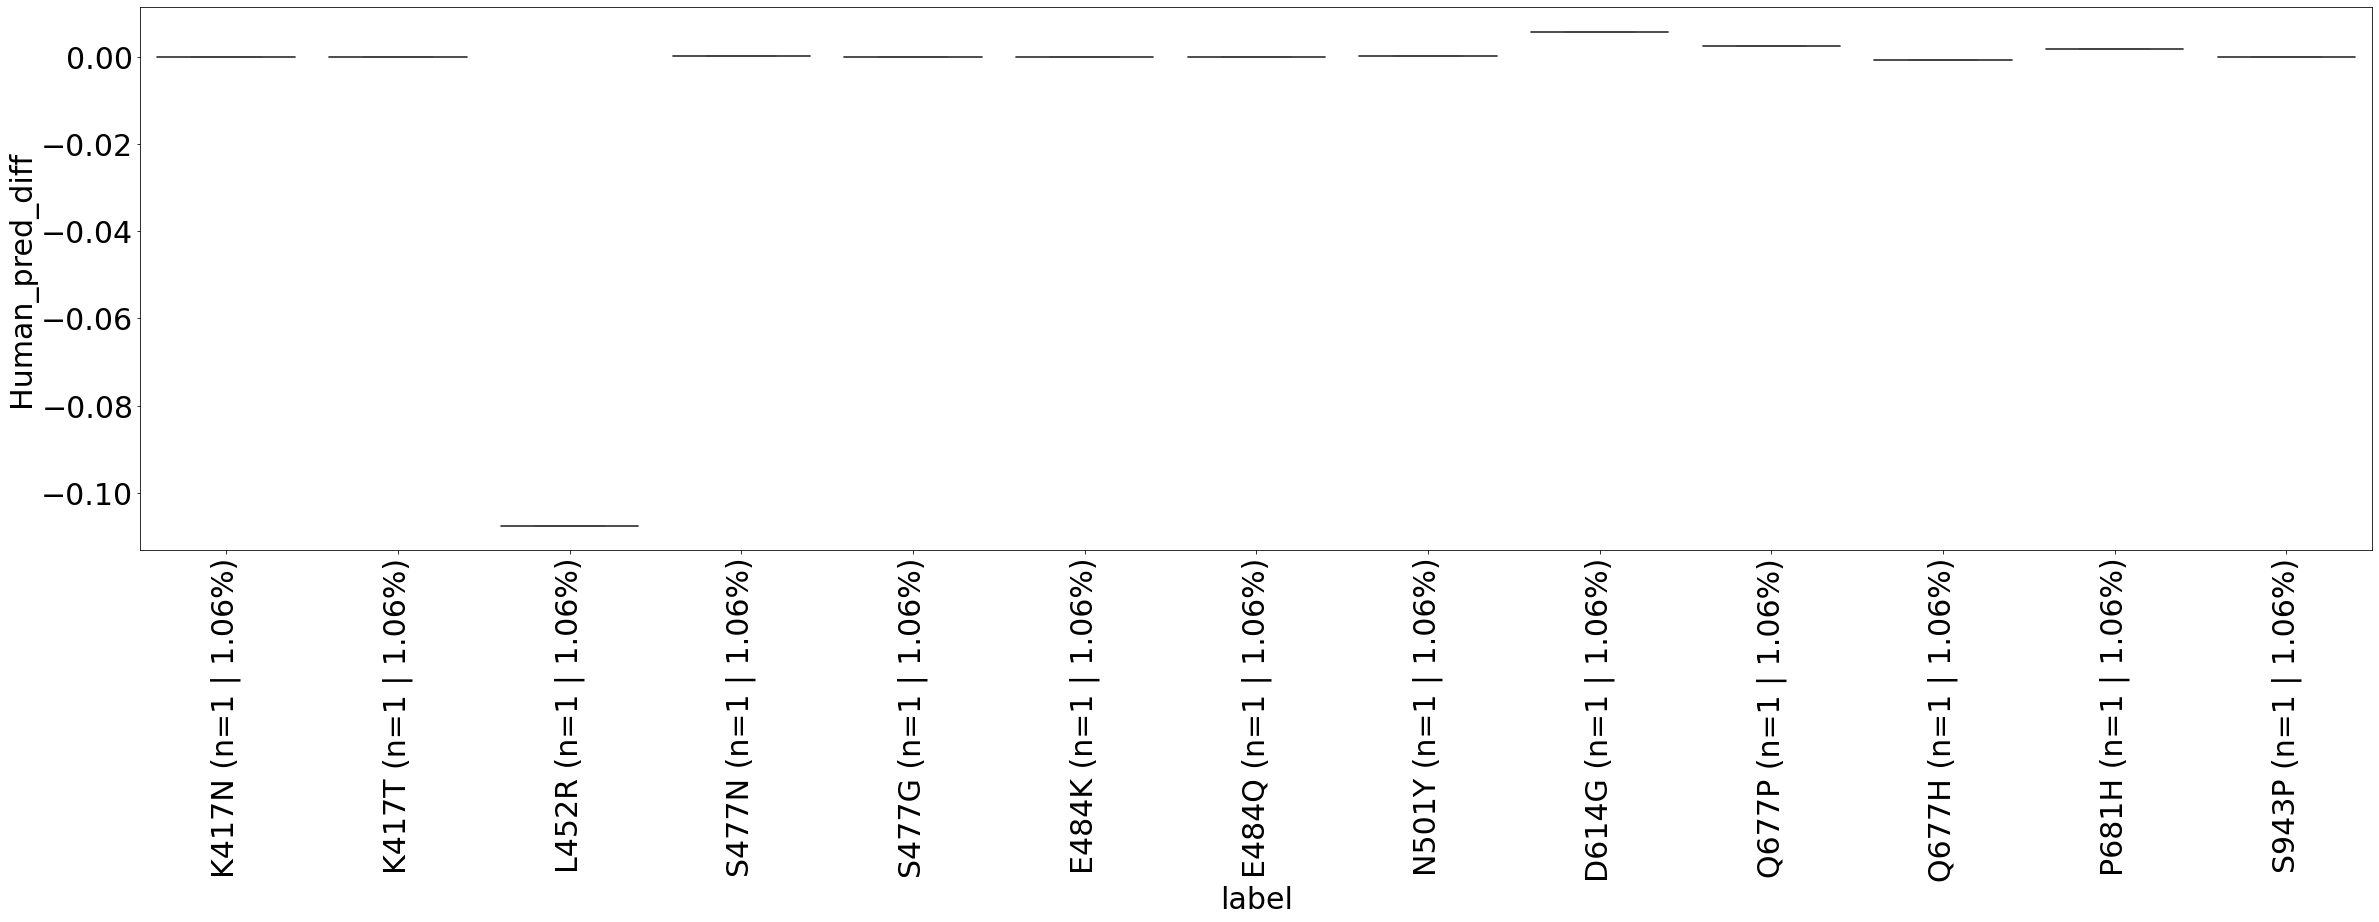

In [50]:
plt.clf()
plt.figure(figsize=(40, 10))
plt.rcParams.update({'font.size': 30})
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30

ax = sns.boxplot(data=known_mutations_df, x="label", y="Human_pred_diff", 
                 order=known_mutations_df.sort_values("perturb_seq_pos")["label"].unique(),
                 boxprops={"facecolor": (.3, .5, .7, .5)})

ax.tick_params(axis='x', rotation=90)
plt.show()

### Identified and Known Mutations

In [51]:
identified_mutations = set(cut_off_df_2["perturbation_id"].unique())
known_mutations = set(s_mutations_df["perturbation_id"].unique())
print(f"identified_mutations = {len(identified_mutations)}")
print(f"known_mutations = {len(known_mutations)}")
print(f"intersection = {identified_mutations.intersection(known_mutations)}")
intersection = list(identified_mutations.intersection(known_mutations))

identified_mutations = 1157
known_mutations = 13
intersection = {'L452R'}


Perturbation id = L452R
L452X


/tmp/ipykernel_402400/430021846.py:15: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=plot_df, x="Human_pred_diff", hue="type", ax=axs[j], legend=True)


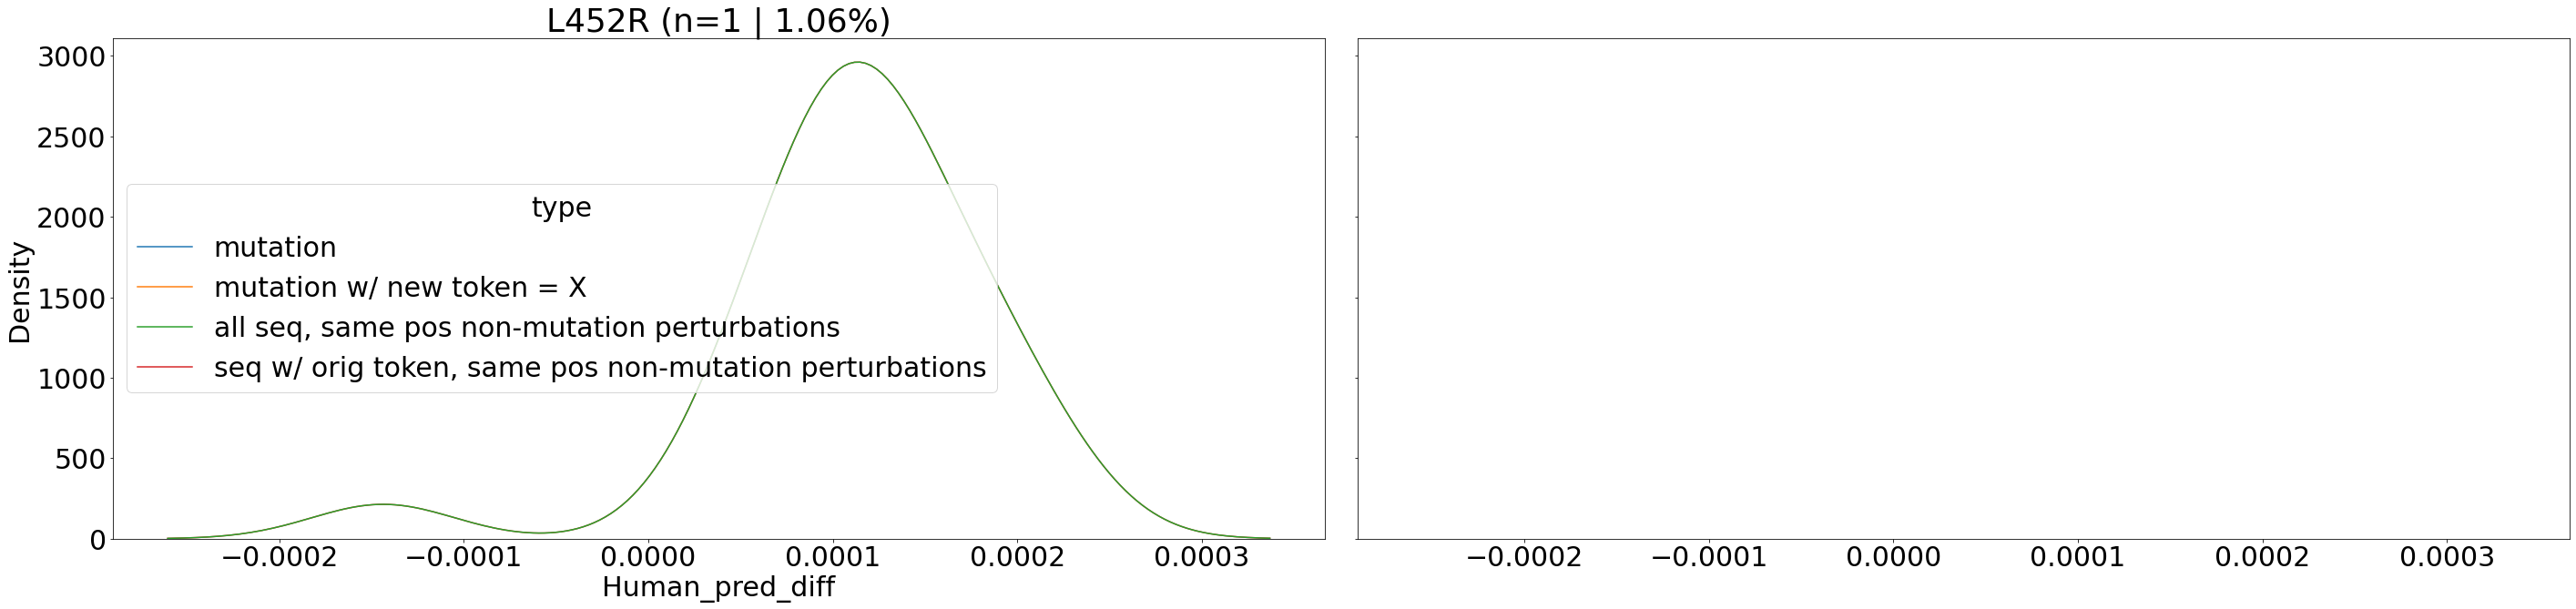

In [52]:
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30
plt.rcParams.update({'font.size': 30})
fig, axs = plt.subplots(1, 2, figsize=(40, 10), sharex=True, sharey=True)

j=0
plot_dfs = []
for i in intersection:
    row = s_mutations_df[s_mutations_df["perturbation_id"] == i]
    plot_df = get_distribution_df(perturbed_output_df, 
                                    orig_token=row["orig_token"].values[0],
                                    perturb_pos=row["pos"].values[0],
                                    perturbation_id=i,
                                    perturbation_id_label=row["label"].values[0])
    sns.kdeplot(data=plot_df, x="Human_pred_diff", hue="type", ax=axs[j], legend=True)
    axs[j].set_title(row["label"].values[0])
    plot_dfs.append(plot_df)
    j += 1
#ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize="30")
plt.tight_layout()
plt.show()


<Figure size 432x288 with 0 Axes>

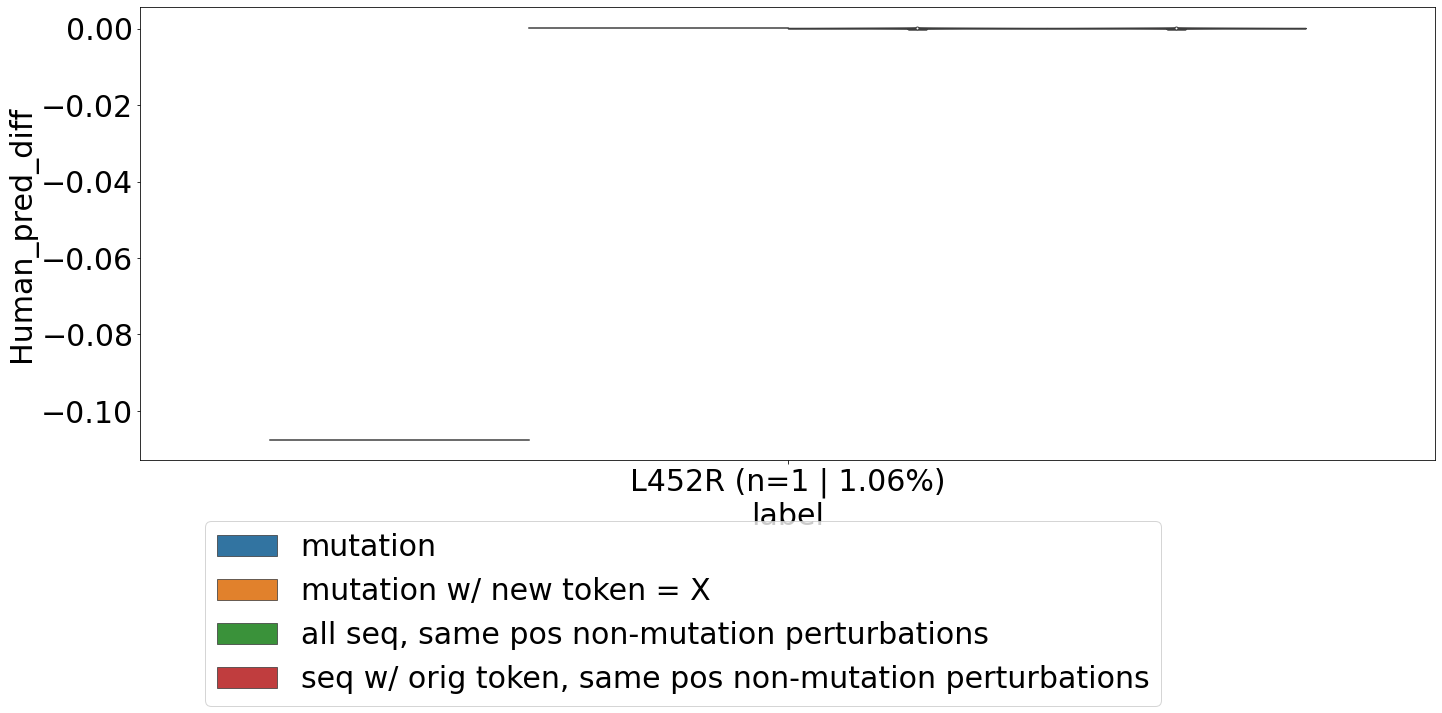

In [53]:
plt.clf()
plt.figure(figsize=(20, 10))
plt.rcParams.update({'font.size': 30})
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30

ax = sns.violinplot(pd.concat(plot_dfs), x="label", y="Human_pred_diff", hue="type")
#ax = (data=pd.concat(plot_dfs), x="perturbation_id", y="Human_pred_diff", hue="type", notch=True)
#ax.tick_params(axis='x', rotation=90)
ax.legend(bbox_to_anchor=(.8, -0.1), fontsize="30")
plt.tight_layout(pad=.2)
plt.show()

<Figure size 432x288 with 0 Axes>

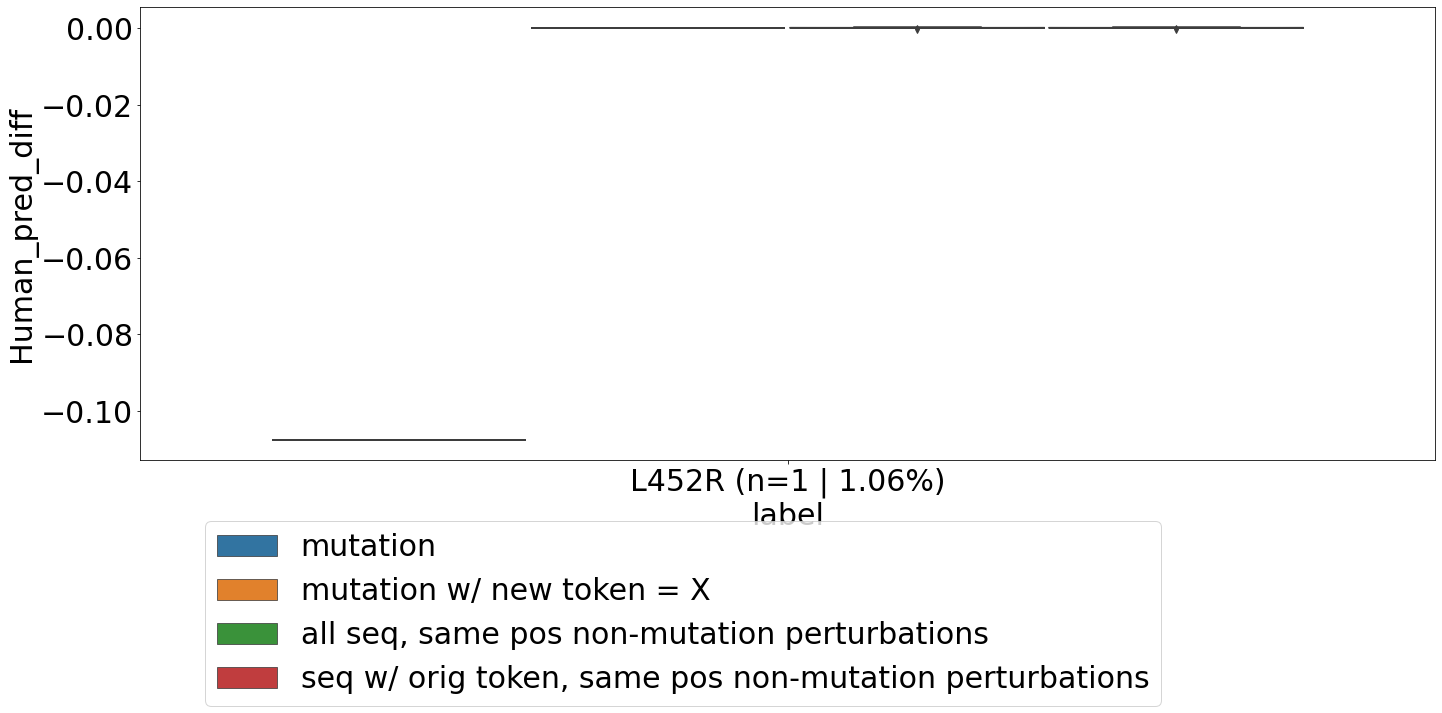

In [54]:
plt.clf()
plt.figure(figsize=(20, 10))
plt.rcParams.update({'font.size': 30})
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30

ax = sns.boxplot(pd.concat(plot_dfs), x="label", y="Human_pred_diff", hue="type", notch=True)
#ax = (data=pd.concat(plot_dfs), x="perturbation_id", y="Human_pred_diff", hue="type", notch=True)
#ax.tick_params(axis='x', rotation=90)
ax.legend(bbox_to_anchor=(.8, -0.1), fontsize="30")
plt.tight_layout(pad=.2)
plt.show()